Hier werden die Ergebnisse eingelesen und ausgewertet

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import math
import random
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import squareform
from riskfolio import HCPortfolio as hc

In [2]:
def gesamt_return(returns):

    total = np.cumprod(1 + returns)
    
    return total

In [3]:
def portfolio_return (returns):
    
    pf_return = returns.mean()
    
    return pf_return

In [4]:
def portfolio_variance (returns):
    
    pf_var = np.var(returns)
    
    return pf_var

In [5]:
def portfolio_volatility (returns):
    variance = portfolio_variance(returns)
    volatility = np.sqrt(variance)
    
    return volatility

In [6]:
def sharpe_ratio (returns):
    pf_return = portfolio_return (returns)
    volatility = portfolio_volatility (returns)
    zins_risikofrei = 0
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [7]:
def sharpe_ratio_one (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.01
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [8]:
def sharpe_ratio_two (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.02
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [9]:
def sortino_ratio (returns): 
    
    zins_risikofrei = 0
        
    temp = (np.minimum(0, returns - zins_risikofrei))**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [10]:
def sortino_ratio_one (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.01
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [11]:
def sortino_ratio_two (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.02
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [12]:
def maximum_drawdown (returns):
    
    returns_kumuliert = (1 + returns).cumprod()
    hochpunkte = returns_kumuliert.cummax()
    
    drawdowns = (returns_kumuliert - hochpunkte) / hochpunkte
    max_drawdown = drawdowns.min()
    
    #print(drawdowns)
    return max_drawdown

In [13]:
def calmar_ratio (returns):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    max_drawdown = maximum_drawdown(returns)
    
    calmar_ratio = annualized_return / (-max_drawdown)
    
    return calmar_ratio

In [14]:
def calmar_ratio_total (returns):
    total_return = (1 + returns).prod() - 1
    
    max_drawdown = maximum_drawdown(returns)
    calmar_ratio_gesamt = total_return / (-max_drawdown)
    
    return calmar_ratio_gesamt

In [15]:
def value_at_risk_func(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = np.percentile(sorted_daily_returns, 100*0.05)
    return value_at_risk

In [16]:
#https://github.com/malctaylor15/VaR-and-Expected-Shortfall-Python/blob/master/Expected%20Shortfall%20and%20Value%20at%20Risk.ipynb

def expected_shortfall(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = value_at_risk_func(returns)
    
    expected_shortfall = sorted_daily_returns[sorted_daily_returns <= value_at_risk].mean()
    
    return expected_shortfall

## Auswertung S&P 500 Voll

In [17]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500 = pd.read_csv(
    'returnsreduziert_neu_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [18]:
df_SP500.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.013798          0.010145                 0.011484   
1     2006-06-02          0.002786         -0.000581                 0.000013   
2     2006-06-05         -0.020002         -0.012682                -0.016373   
3     2006-06-06         -0.001997          0.003065                 0.001059   
4     2006-06-07         -0.007464         -0.003498                -0.005172   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.001961          0.000892                 0.000903   
4776  2025-05-27          0.017185          0.004463                 0.007647   
4777  2025-05-28         -0.009502         -0.006821                -0.005586   
4778  2025-05-29          0.004364          0.002687                 0.002789   
4779  2025-05-30          0.000347          0.006106                 0.005595

In [19]:
df_SP500.head()

Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0  2006-06-01          0.013798          0.010145                 0.011484   
1  2006-06-02          0.002786         -0.000581                 0.000013   
2  2006-06-05         -0.020002         -0.012682                -0.016373   
3  2006-06-06         -0.001997          0.003065                 0.001059   
4  2006-06-07         -0.007464         -0.003498                -0.005172   

   Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
0            0.013118                 0.013199  0.012306  0.012939  
1            0.002866                 0.002810  0.002084  0.004880  
2           -0.017938                -0.018207 -0.015897 -0.016388  
3           -0.001424                -0.001513 -0.000608  0.000167  
4           -0.005358                -0.005629 -0.003582 -0.002455

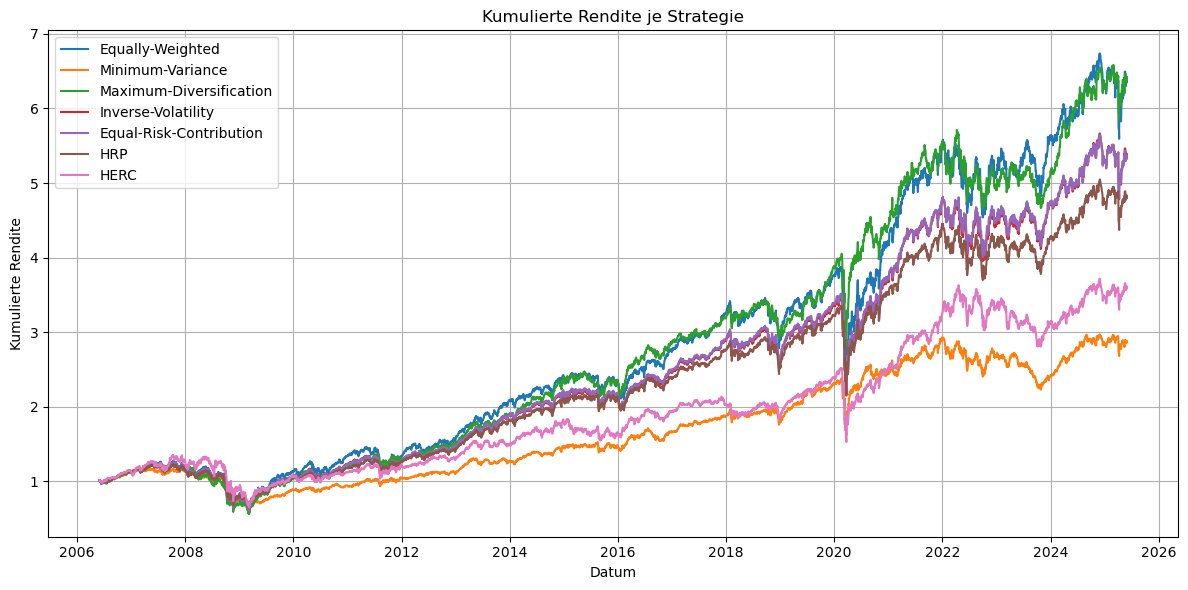

In [20]:
df_SP500["Date"] = pd.to_datetime(df_SP500["Date"])

#Date-Spalte als Index setzen
df_SP500 = df_SP500.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
letzte_returns = kumulative_returns.iloc[-1]
print(letzte_returns)

Equally-Weighted           6.376650
Minimum-Variance           2.879790
Maximum-Diversification    6.422886
Inverse-Volatility         5.378948
Equal-Risk-Contribution    5.356755
HRP                        4.829147
HERC                       3.609769
Name: 2025-05-30 00:00:00, dtype: float64


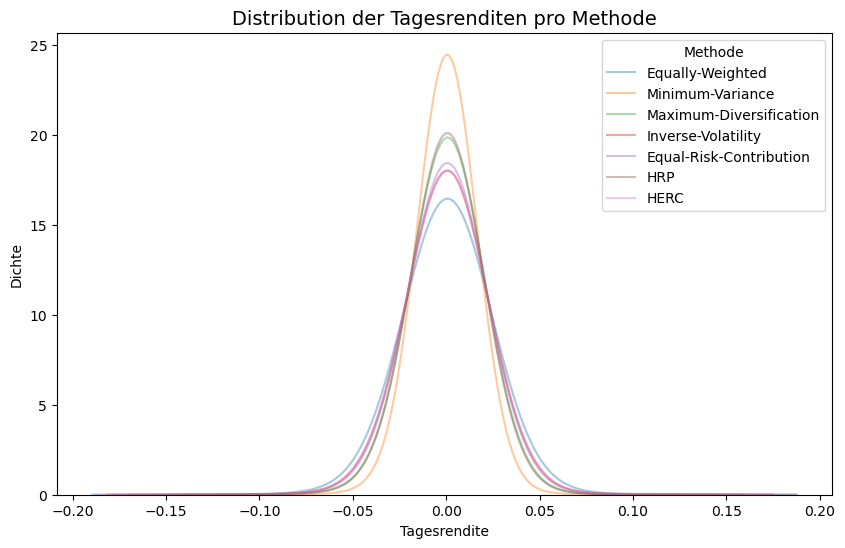

In [22]:
plt.figure(figsize=(10, 6))
for col in df_SP500.columns:
    sb.kdeplot(df_SP500[col], label=col, fill=False, alpha=0.4, bw_adjust=9)

plt.title("Distribution der Tagesrenditen pro Methode", fontsize=14)
plt.xlabel("Tagesrendite")
plt.ylabel("Dichte")
plt.legend(title="Methode")
plt.show()

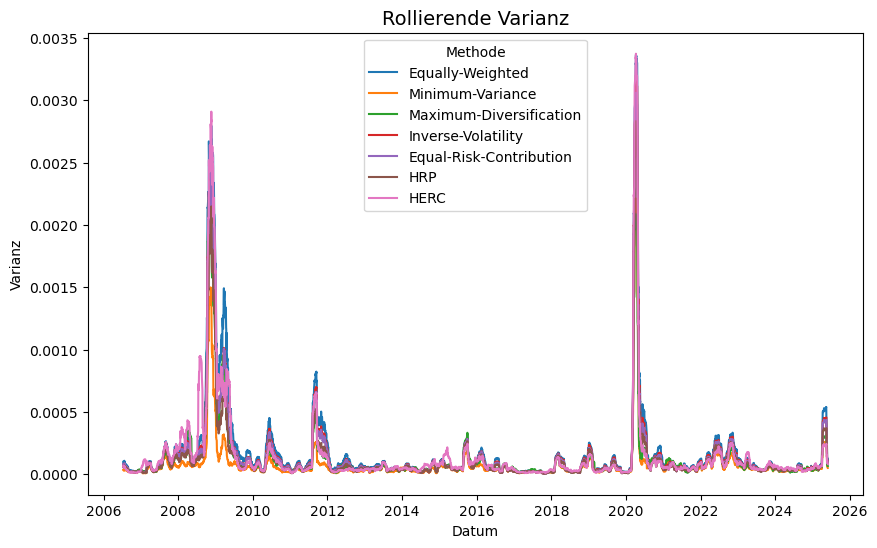

In [23]:
rollierende_varianz = df_SP500.rolling(window=30).var()

plt.figure(figsize=(10, 6))
for col in rollierende_varianz.columns:
    plt.plot(rollierende_varianz.index, rollierende_varianz[col], label=col)

plt.title("Rollierende Varianz", fontsize=14)
plt.xlabel("Datum")
plt.ylabel("Varianz")
plt.legend(title="Methode")
plt.show()

In [24]:
#Letzten Wert jedes Jahres extrahieren
df_kum_endwerte = kumulative_returns.resample('Y').last()

# Jahr als Spalte
df_kum_endwerte.index = df_kum_endwerte.index.year
df_kum_endwerte.index.name = "Jahr"

df_kum_endwerte

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Jahr                                                                
2006          1.130170          1.120097                 1.118500   
2007          1.191924          1.136005                 1.161628   
2008          0.799785          0.767000                 0.709488   
2009          1.122739          0.878124                 1.032509   
2010          1.334010          0.942142                 1.212036   
2011          1.323095          1.043897                 1.282067   
2012          1.555442          1.106868                 1.495976   
2013          2.094467          1.276767                 1.911125   
2014          2.384896          1.446768                 2.348423   
2015          2.323927          1.461631                 2.329069   
2016          2.734598          1.654172                 2.848076   
2017          3.240382          1.870130                 3.184165   
2018          2.945755          1.816234                 3.018147   
2019          3.761800          2.321396                 3.885195   
2020          4.228493          2.453280                 4.431573   
2021          5.523389          2.931739                 5.553429   
2022          5.120126          2.672260                 4.948669   
2023          5.624206          2.407349                 5.099798   
2024          6.291178          2.838017                 6.276682   
2025          6.376650          2.879790                 6.422886   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Jahr                                                                   
2006            1.132371                 1.133540  1.130281  1.143267  
2007            1.177440                 1.180292  1.166458  1.269179  
2008            0.798378                 0.797588  0.811561  0.920495  
2009            1.062152                 1.060095  1.039048  1.056999  
2010            1.227136                 1.221049  1.174733  1.119576  
2011            1.257647                 1.264662  1.258045  1.211045  
2012            1.441294                 1.448086  1.408863  1.295010  
2013            1.901730                 1.908017  1.828060  1.506214  
2014            2.164411                 2.183903  2.083195  1.785461  
2015            2.137349                 2.154657  2.106017  1.635231  
2016            2.450945                 2.472360  2.369363  1.931460  
2017            2.878608                 2.891230  2.752373  2.032424  
2018            2.643271                 2.675519  2.564549  1.882292  
2019            3.359647                 3.393264  3.231230  2.395166  
2020            3.728443                 3.754131  3.547416  2.525231  
2021            4.779528                 4.798327  4.452355  3.251775  
2022            4.449584                 4.502432  4.164575  3.325716  
2023            4.737282                 4.740107  4.267650  3.119420  
2024            5.291389                 5.283711  4.737941  3.468485  
2025            5.378948                 5.356755  4.829147  3.609769

In [25]:
#jährliche kumulierte Rendite berechnen
jährlich_kum_returns = (1 + df_SP500).resample('Y').prod() - 1

# Jahr als Spalte
jährlich_kum_returns.index = jährlich_kum_returns.index.year
jährlich_kum_returns.index.name = "Jahr"

jährlich_kum_returns

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Jahr                                                                
2006          0.130170          0.120097                 0.118500   
2007          0.054641          0.014202                 0.038558   
2008         -0.328997         -0.324827                -0.389229   
2009          0.403800          0.144882                 0.455288   
2010          0.188175          0.072903                 0.173874   
2011         -0.008183          0.108004                 0.057780   
2012          0.175609          0.060323                 0.166847   
2013          0.346541          0.153495                 0.277510   
2014          0.138665          0.133149                 0.228817   
2015         -0.025565          0.010274                -0.008241   
2016          0.176714          0.131730                 0.222839   
2017          0.184957          0.130553                 0.118005   
2018         -0.090924         -0.028819                -0.052138   
2019          0.277024          0.278137                 0.287278   
2020          0.124061          0.056813                 0.140631   
2021          0.306231          0.195028                 0.253151   
2022         -0.073010         -0.088507                -0.108899   
2023          0.098451         -0.099134                 0.030539   
2024          0.118589          0.178897                 0.230771   
2025          0.013586          0.014719                 0.023293   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Jahr                                                                   
2006            0.132371                 0.133540  0.130281  0.143267  
2007            0.039801                 0.041244  0.032007  0.110133  
2008           -0.321937                -0.324245 -0.304252 -0.274732  
2009            0.330386                 0.329125  0.280308  0.148295  
2010            0.155331                 0.151830  0.130586  0.059203  
2011            0.024864                 0.035718  0.070920  0.081700  
2012            0.146024                 0.145037  0.119883  0.069332  
2013            0.319460                 0.317613  0.297543  0.163091  
2014            0.138127                 0.144593  0.139566  0.185397  
2015           -0.012503                -0.013392  0.010955 -0.084141  
2016            0.146722                 0.147450  0.125044  0.181154  
2017            0.174489                 0.169421  0.161651  0.052274  
2018           -0.081754                -0.074609 -0.068241 -0.073869  
2019            0.271019                 0.268264  0.259960  0.272473  
2020            0.109772                 0.106348  0.097853  0.054303  
2021            0.281910                 0.278146  0.255098  0.287714  
2022           -0.069033                -0.061666 -0.064635  0.022739  
2023            0.064657                 0.052788  0.024750 -0.062031  
2024            0.116967                 0.114682  0.110199  0.111901  
2025            0.016547                 0.013824  0.019250  0.040733

In [26]:
from IPython.display import display, HTML

display(HTML(jährlich_kum_returns.to_html()))

In [27]:
reorganisiert = jährlich_kum_returns.reset_index().melt(id_vars="Jahr", var_name="Strategie", value_name="Rendite")
reorganisiert.head()

Jahr         Strategie   Rendite
0  2006  Equally-Weighted  0.130170
1  2007  Equally-Weighted  0.054641
2  2008  Equally-Weighted -0.328997
3  2009  Equally-Weighted  0.403800
4  2010  Equally-Weighted  0.188175

In [28]:
import plotly.express as px

fig = px.bar(reorganisiert, 
             x="Jahr", y="Rendite", color="Strategie", 
             barmode="group",
             text="Rendite",
             title="Jährliche kumulierte Renditen je Strategie",
             color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(yaxis_tickformat='.0%', xaxis={'type': 'category'})
fig.show()

In [29]:
#jährliche vola

jährliche_vola = (df_SP500.groupby(df_SP500.index.year).std()
    .apply(lambda x: x * np.sqrt(252))
    * 100
)

jährliche_vola

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         10.850305          7.359608                 9.796778   
2007         16.605365         11.744713                14.298903   
2008         43.754165         27.938197                38.126414   
2009         33.832542         15.521473                25.991478   
2010         19.064076         10.834555                13.965779   
2011         24.695137         13.327549                17.684774   
2012         13.325848          7.957836                10.446532   
2013         11.755683          9.305702                10.165798   
2014         11.384021          8.733128                10.877259   
2015         15.293645         12.456519                15.193832   
2016         13.755790         10.574218                12.298026   
2017          7.004504          5.955213                 7.198640   
2018         14.913370         11.575526                12.610581   
2019         11.937176          8.823337                10.509063   
2020         38.046632         28.768630                29.253876   
2021         13.268109         11.080243                12.426833   
2022         21.578161         15.965089                18.485860   
2023         13.351530         10.608608                11.432250   
2024         10.817232          8.564069                 9.632042   
2025         22.648075         16.248456                17.652676   

      Inverse-Volatility  Equal-Risk-Contribution        HRP       HERC  
Date                                                                     
2006            9.711614                 9.726735   8.816065   8.494903  
2007           15.801689                15.559509  14.301744  17.785744  
2008           39.616905                39.188103  35.435169  45.314215  
2009           27.665761                27.473281  22.978322  28.156025  
2010           17.021024                16.384749  14.545386  14.687691  
2011           22.293790                21.588202  18.857587  19.167055  
2012           11.622826                11.331280   9.836687   8.843855  
2013           11.131545                10.909427  10.376468  11.046880  
2014           10.908578                10.714730  10.169144  12.175060  
2015           14.865550                14.766596  14.261670  16.251605  
2016           12.731242                12.538840  11.807452  12.397243  
2017            6.546212                 6.356337   6.224726   6.886727  
2018           14.325578                13.880670  13.400828  12.953378  
2019           11.129075                10.509854  10.011195   9.344556  
2020           36.296635                35.272100  33.483879  35.203933  
2021           12.150841                11.426821  10.907387  11.903769  
2022           20.239942                19.618618  18.592557  17.911196  
2023           12.537177                12.060022  11.430292  13.456640  
2024           10.321997                 9.926843   9.465217  10.307825  
2025           21.051475                20.563246  19.172003  17.112084

<Figure size 1000x600 with 0 Axes>

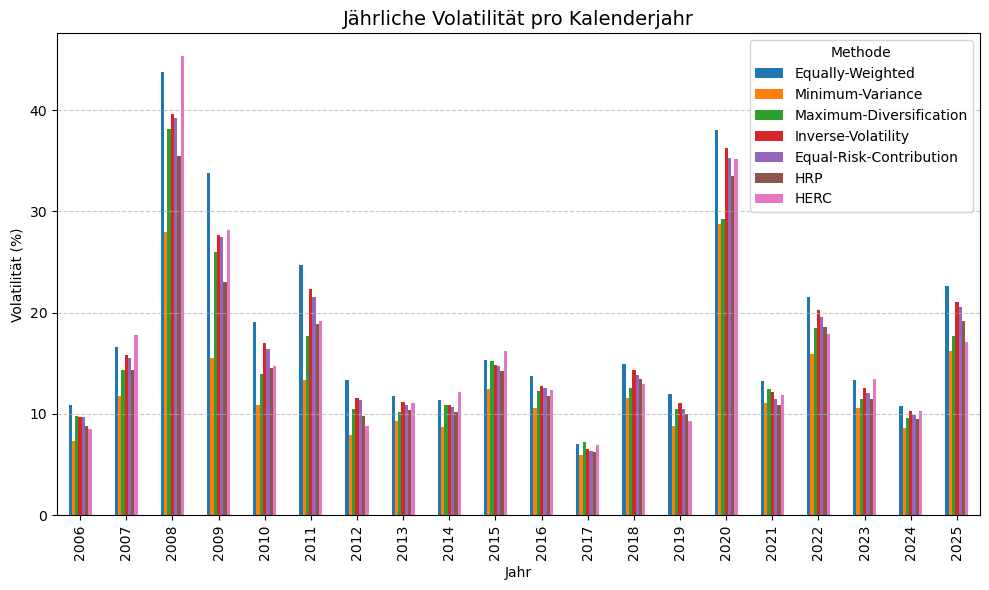

In [30]:
plt.figure(figsize=(10, 6))
jährliche_vola.plot(kind="bar", figsize=(10, 6))

plt.title("Jährliche Volatilität pro Kalenderjahr", fontsize=14)
plt.xlabel("Jahr")
plt.ylabel("Volatilität (%)")
plt.legend(title="Methode")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Sharpe Ratio

In [31]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sharpe_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [32]:
sharpe_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          1.981530          2.670496                 2.002445   
2007          0.405490          0.179507                 0.337785   
2008         -0.691100         -1.263189                -1.098859   
2009          1.173692          0.951183                 1.577296   
2010          1.001687          0.704973                 1.220346   
2011          0.090470          0.837906                 0.407035   
2012          1.293090          0.783263                 1.544358   
2013          2.596267          1.584515                 2.465946   
2014          1.200152          1.478089                 1.953120   
2015         -0.093203          0.144546                 0.021474   
2016          1.254461          1.225719                 1.701094   
2017          2.473111          2.103063                 1.595127   
2018         -0.568210         -0.196176                -0.364031   
2019          2.113257          2.832238                 2.461641   
2020          0.498540          0.335892                 0.595819   
2021          2.084777          1.667155                 1.882364   
2022         -0.245728         -0.503996                -0.534864   
2023          0.777059         -0.940746                 0.322855   
2024          1.092344          1.968961                 2.208941   
2025          0.260105          0.304092                 0.411582   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.236138                 2.250948  2.418119  2.736226  
2007            0.327602                 0.339238  0.293205  0.680096  
2008           -0.780645                -0.802148 -0.844735 -0.482629  
2009            1.172452                 1.175280  1.192674  0.633008  
2010            0.935185                 0.946468  0.918335  0.465760  
2011            0.222131                 0.271095  0.458602  0.506741  
2012            1.242716                 1.264064  1.211904  0.809765  
2013            2.552332                 2.589186  2.568324  1.425949  
2014            1.243252                 1.316788  1.338433  1.460943  
2015           -0.010487                -0.017655  0.147849 -0.460367  
2016            1.141416                 1.162052  1.059058  1.408088  
2017            2.505058                 2.509482  2.453415  0.778783  
2018           -0.527079                -0.492342 -0.463404 -0.530911  
2019            2.215844                 2.319305  2.363899  2.631654  
2020            0.469343                 0.463843  0.447228  0.327533  
2021            2.109664                 2.210053  2.142668  2.189028  
2022           -0.254487                -0.228413 -0.268669  0.215874  
2023            0.567350                 0.491031  0.273082 -0.413313  
2024            1.125593                 1.145681  1.154164  1.082802  
2025            0.298004                 0.267804  0.342185  0.664822

In [33]:
#Durchschnitt
sharpe_durchschnitt = sharpe_jahresweise.mean(axis=1)

sharpe_durchschnitt = sharpe_durchschnitt.to_frame(name="Sharpe_Mittelwert")

sharpe_durchschnitt.info

<bound method DataFrame.info of       Sharpe_Mittelwert
Date                   
2006           2.327986
2007           0.366132
2008          -0.851901
2009           1.125084
2010           0.884679
2011           0.399140
2012           1.164166
2013           2.254646
2014           1.427254
2015          -0.038263
2016           1.278841
2017           2.059720
2018          -0.448879
2019           2.419691
2020           0.448314
2021           2.040816
2022          -0.260040
2023           0.153902
2024           1.396927
2025           0.364085>

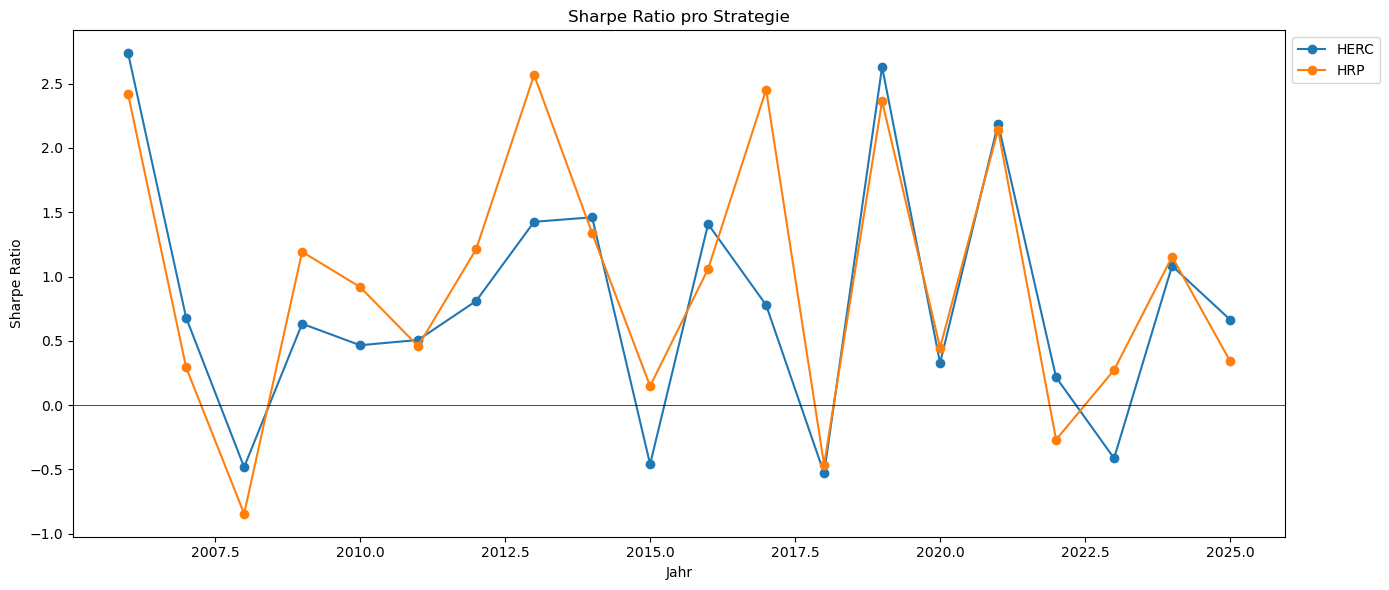

In [34]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "HERC"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

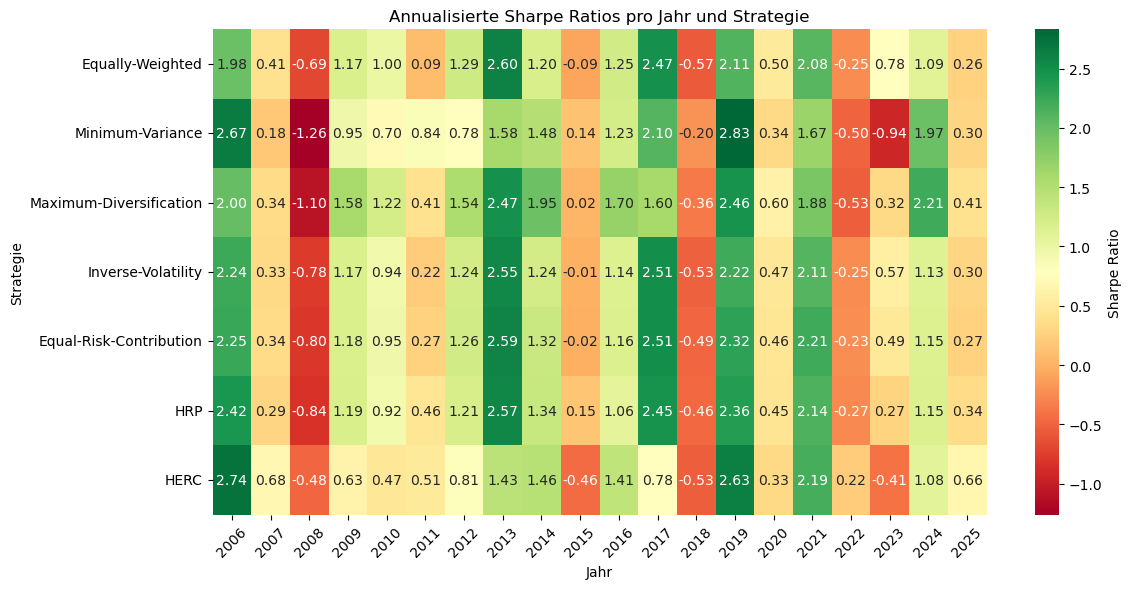

In [35]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
#Simulation mit synthetischen Werten

np.random.seed(42)

#Simulation: 20 Jahre, 252 Handelstage pro Jahr
years = 20
days_per_year = 252
mu_daily = 0.0005      
sigma_daily = 0.01      

#Simulierte tägliche Renditen (normalverteilt)
daily_returns = np.random.normal(loc=mu_daily, scale=sigma_daily, size=(days_per_year*years,))

#Datum-Index erstellen
dates = pd.date_range(start="2000-01-01", periods=days_per_year*years, freq='B')
df_sim = pd.DataFrame(daily_returns, index=dates, columns=['Strategy'])

#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    return (returns_daily.mean() / returns_daily.std()) * np.sqrt(days_per_year)

#Sharpe Ratios pro Jahr berechnen
sharpe_by_year = df_sim.groupby(df_sim.index.year).apply(lambda x: x.apply(sharpe_annual))

print(sharpe_by_year)

      Strategy
2000  0.938821
2001  0.686188
2002  0.254476
2003  3.547887
2004  1.809797
2005  2.077011
2006  1.241718
2007  0.797057
2008  1.363644
2009  0.511714
2010  2.034882
2011 -0.234316
2012  0.727365
2013  1.306639
2014 -0.508489
2015  0.455300
2016 -1.627256
2017  1.034871
2018  0.593904
2019  2.021202


In [37]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe = df_SP500.apply(sharpe_annual)

print(gesamt_sharpe)

Equally-Weighted           0.573037
Minimum-Variance           0.468060
Maximum-Diversification    0.655239
Inverse-Volatility         0.561481
Equal-Risk-Contribution    0.568681
HRP                        0.572165
HERC                       0.449293
dtype: float64


#### Sortino

In [38]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sortino_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

In [39]:
sortino_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.269566          4.524440                 3.311656   
2007          0.542054          0.242770                 0.448462   
2008         -0.957707         -1.731241                -1.459187   
2009          1.747049          1.375057                 2.325016   
2010          1.455255          0.989680                 1.716971   
2011          0.122904          1.182612                 0.544663   
2012          1.971896          1.093153                 2.440737   
2013          3.940403          2.274401                 3.662014   
2014          1.680983          2.222984                 3.027334   
2015         -0.129305          0.196848                 0.029623   
2016          1.802213          1.763815                 2.603873   
2017          3.913458          3.236385                 2.302517   
2018         -0.731796         -0.259096                -0.479871   
2019          3.044574          4.387382                 3.522652   
2020          0.687535          0.468130                 0.830370   
2021          3.109933          2.422061                 2.853316   
2022         -0.347543         -0.674753                -0.722100   
2023          1.143862         -1.237918                 0.458624   
2024          1.576149          2.953785                 3.497650   
2025          0.378274          0.433108                 0.591334   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.729339                 3.772671  4.082989  4.712232  
2007            0.436943                 0.451159  0.390197  0.931709  
2008           -1.083921                -1.111589 -1.177441 -0.708000  
2009            1.724711                 1.728286  1.746229  0.895908  
2010            1.353718                 1.367657  1.320093  0.662736  
2011            0.302272                 0.369139  0.625703  0.696436  
2012            1.883705                 1.917540  1.819272  1.220261  
2013            3.901410                 3.940427  3.927184  2.067459  
2014            1.749895                 1.865309  1.903660  2.163351  
2015           -0.014568                -0.024526  0.206399 -0.603066  
2016            1.635540                 1.669917  1.521949  1.998114  
2017            3.978337                 3.967363  3.834915  1.079314  
2018           -0.678256                -0.633844 -0.596964 -0.675420  
2019            3.208217                 3.381909  3.485827  4.060459  
2020            0.644465                 0.634553  0.607708  0.447118  
2021            3.129994                 3.294395  3.193148  3.224533  
2022           -0.359319                -0.321357 -0.376067  0.296303  
2023            0.821451                 0.709636  0.390466 -0.551254  
2024            1.624033                 1.662947  1.664927  1.543955  
2025            0.429670                 0.385285  0.490059  0.931215

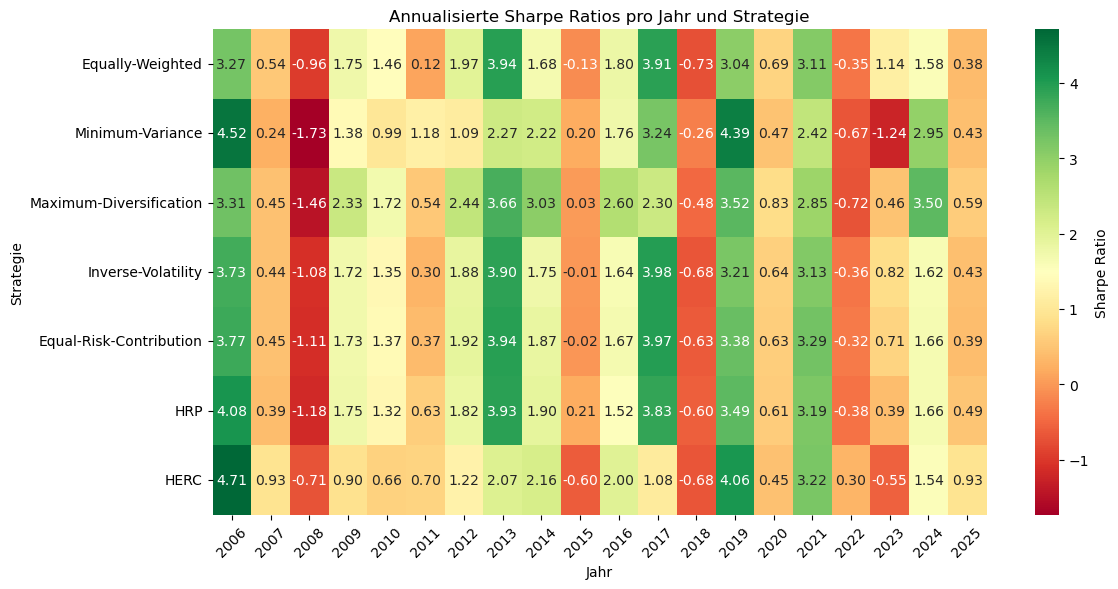

In [40]:
plt.figure(figsize=(12,6))
sb.heatmap(sortino_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

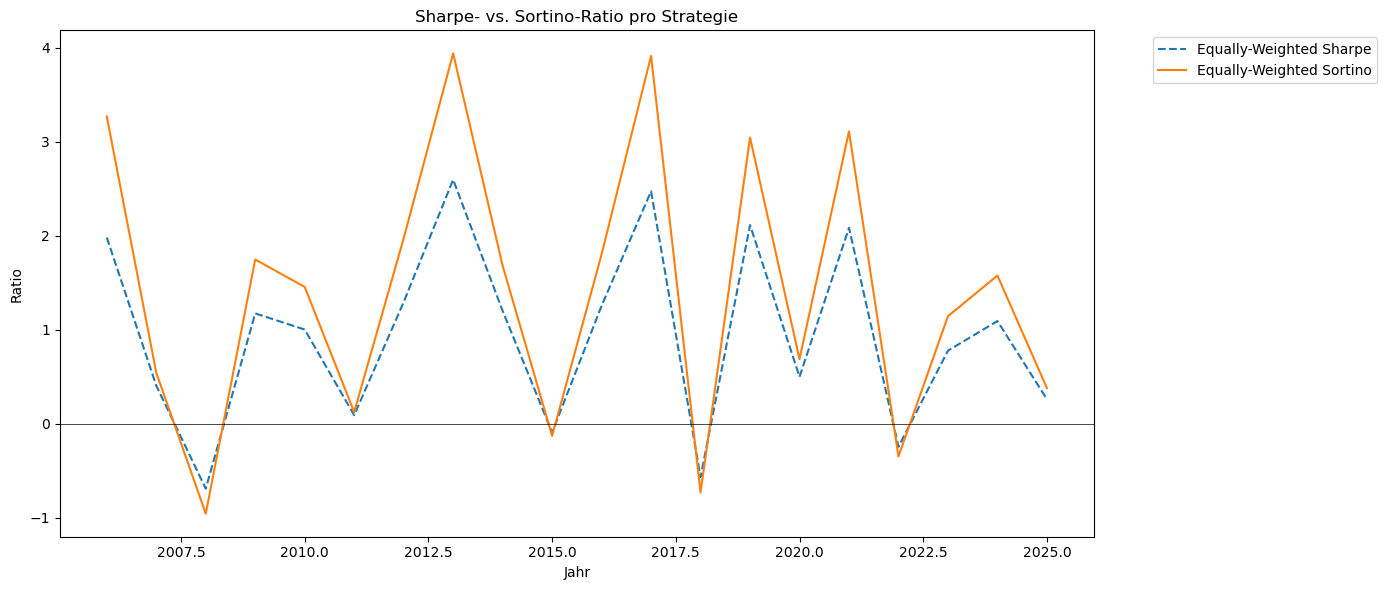

In [41]:
#Vergleich Sharpe und Sortino
strategies = sharpe_jahresweise.columns
jahre = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Equally-Weighted"

plt.plot(jahre, sharpe_jahresweise[strategie], label=f"{strategie} Sharpe", linestyle='--')
plt.plot(jahre, sortino_jahresweise[strategie], label=f"{strategie} Sortino", linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Jahr")
plt.ylabel("Ratio")
plt.title("Sharpe- vs. Sortino-Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino = df_SP500.apply(sortino_annual)

print(gesamt_sortino)

Equally-Weighted           0.809622
Minimum-Variance           0.654364
Maximum-Diversification    0.915225
Inverse-Volatility         0.789849
Equal-Risk-Contribution    0.799051
HRP                        0.802410
HERC                       0.633972
dtype: float64


#### Maximum Drawdown

In [43]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(maximum_drawdown))

In [44]:
max_drawdown_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.052979         -0.032273                -0.043858   
2007         -0.099265         -0.070417                -0.096438   
2008         -0.483344         -0.368682                -0.506949   
2009         -0.310347         -0.154376                -0.235066   
2010         -0.153293         -0.068603                -0.134655   
2011         -0.216279         -0.092658                -0.131472   
2012         -0.098626         -0.041336                -0.053651   
2013         -0.056744         -0.069680                -0.059743   
2014         -0.070468         -0.046066                -0.046444   
2015         -0.124375         -0.090481                -0.156466   
2016         -0.088312         -0.100147                -0.073029   
2017         -0.033195         -0.026323                -0.034849   
2018         -0.195360         -0.113968                -0.149997   
2019         -0.064935         -0.040606                -0.047253   
2020         -0.388963         -0.321852                -0.306649   
2021         -0.054654         -0.079601                -0.071041   
2022         -0.186833         -0.179719                -0.185572   
2023         -0.135492         -0.181870                -0.116104   
2024         -0.076224         -0.049313                -0.051888   
2025         -0.148637         -0.095565                -0.111890   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.045096                -0.046456 -0.038923 -0.038263  
2007           -0.095165                -0.094013 -0.089005 -0.111180  
2008           -0.448676                -0.450233 -0.410427 -0.449431  
2009           -0.275560                -0.273151 -0.238597 -0.313448  
2010           -0.133739                -0.127631 -0.108223 -0.096925  
2011           -0.182519                -0.173535 -0.148838 -0.160499  
2012           -0.077987                -0.073191 -0.058999 -0.065574  
2013           -0.057079                -0.056989 -0.057178 -0.073992  
2014           -0.065171                -0.061960 -0.055663 -0.084924  
2015           -0.111565                -0.113840 -0.102251 -0.155467  
2016           -0.076883                -0.074880 -0.068265 -0.086938  
2017           -0.029049                -0.026455 -0.026201 -0.053111  
2018           -0.183574                -0.177056 -0.169560 -0.120569  
2019           -0.057366                -0.051717 -0.045975 -0.032321  
2020           -0.378184                -0.371679 -0.359235 -0.394142  
2021           -0.049601                -0.051496 -0.055487 -0.061542  
2022           -0.178175                -0.168138 -0.169464 -0.167161  
2023           -0.131284                -0.126098 -0.123639 -0.187511  
2024           -0.075298                -0.072541 -0.068709 -0.079864  
2025           -0.132698                -0.130012 -0.117215 -0.092964

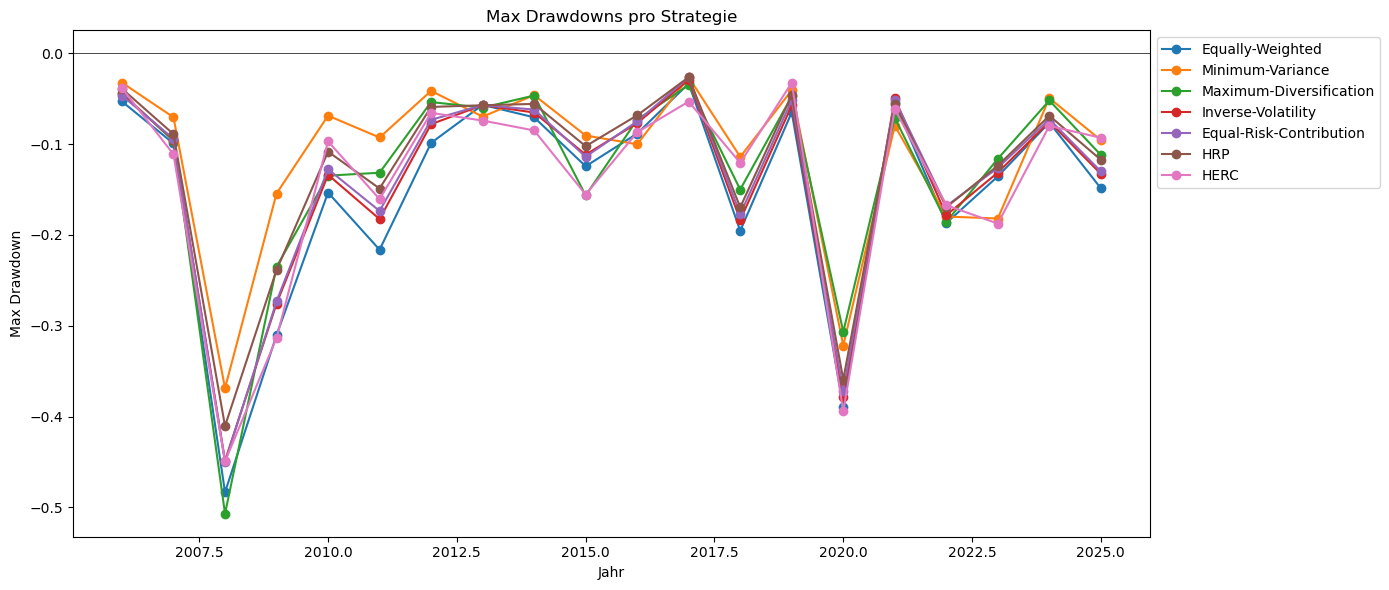

In [45]:
#Plotten der MDDs
strategien = max_drawdown_jahresweise.columns
years = max_drawdown_jahresweise.index

plt.figure(figsize=(14,6))

for strategie in strategies:
    plt.plot(years, max_drawdown_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  # Null-Linie
plt.xlabel("Jahr")
plt.ylabel("Max Drawdown")
plt.title("Max Drawdowns pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_total = df_SP500.apply(maximum_drawdown)

max_drawdown_total.info

<bound method Series.info of Equally-Weighted          -0.541637
Minimum-Variance          -0.440637
Maximum-Diversification   -0.550633
Inverse-Volatility        -0.515301
Equal-Risk-Contribution   -0.516976
HRP                       -0.478981
HERC                      -0.519767
dtype: float64>

#### Calmar Ratio

In [47]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(calmar_ratio_total))

In [48]:
calmar_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.457012          3.721250                 2.701901   
2007          0.550462          0.201687                 0.399827   
2008         -0.680668         -0.881051                -0.767787   
2009          1.301125          0.938502                 1.936848   
2010          1.227556          1.062675                 1.291256   
2011         -0.037833          1.165624                 0.439483   
2012          1.780566          1.459344                 3.109851   
2013          6.107092          2.202850                 4.645041   
2014          1.967770          2.890421                 4.926708   
2015         -0.205545          0.113544                -0.052673   
2016          2.001029          1.315373                 3.051389   
2017          5.571806          4.959587                 3.386201   
2018         -0.465415         -0.252871                -0.347596   
2019          4.266189          6.849726                 6.079520   
2020          0.318954          0.176518                 0.458605   
2021          5.603046          2.450065                 3.563430   
2022         -0.390778         -0.492474                -0.586826   
2023          0.726617         -0.545080                 0.263035   
2024          1.555801          3.627794                 4.447478   
2025          0.091404          0.154024                 0.208181   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.935340                 2.874539  3.347185  3.744283  
2007            0.418228                 0.438710  0.359612  0.990588  
2008           -0.717527                -0.720172 -0.741307 -0.611289  
2009            1.198965                 1.204919  1.174817  0.473107  
2010            1.161450                 1.189599  1.206639  0.610807  
2011            0.136225                 0.205823  0.476489  0.509036  
2012            1.872404                 1.981619  2.031946  1.057314  
2013            5.596818                 5.573241  5.203798  2.204167  
2014            2.119467                 2.333644  2.507355  2.183094  
2015           -0.112071                -0.117637  0.107142 -0.541214  
2016            1.908394                 1.969144  1.831747  2.083722  
2017            6.006700                 6.404148  6.169585  0.984238  
2018           -0.445347                -0.421386 -0.402457 -0.612665  
2019            4.724396                 5.187125  5.654324  8.430336  
2020            0.290261                 0.286129  0.272392  0.137776  
2021            5.683542                 5.401281  4.597466  4.675066  
2022           -0.387444                -0.366759 -0.381409  0.136028  
2023            0.492499                 0.418629  0.200183 -0.330812  
2024            1.553389                 1.580915  1.603857  1.401134  
2025            0.124701                 0.106332  0.164227  0.438161

In [49]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total = df_SP500.apply(calmar_ratio)

calmar_total.info

<bound method Series.info of Equally-Weighted           0.189425
Minimum-Variance           0.130145
Maximum-Diversification    0.187093
Inverse-Volatility         0.179998
Equal-Risk-Contribution    0.178954
HRP                        0.180716
HERC                       0.134706
dtype: float64>

In [50]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total_2 = df_SP500.apply(calmar_ratio_total)

calmar_total_2.info

<bound method Series.info of Equally-Weighted           9.926670
Minimum-Variance           4.266075
Maximum-Diversification    9.848461
Inverse-Volatility         8.497851
Equal-Risk-Contribution    8.427376
HRP                        7.994368
HERC                       5.021039
dtype: float64>

#### Value at Risk

In [51]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.009914         -0.006521                -0.008183   
2007         -0.020665         -0.013521                -0.016403   
2008         -0.046281         -0.028654                -0.042962   
2009         -0.032482         -0.016027                -0.027003   
2010         -0.018698         -0.010955                -0.014819   
2011         -0.025708         -0.011398                -0.016373   
2012         -0.012795         -0.008497                -0.010128   
2013         -0.011531         -0.008410                -0.009954   
2014         -0.011924         -0.009163                -0.011083   
2015         -0.016243         -0.013080                -0.013903   
2016         -0.013888         -0.011076                -0.011727   
2017         -0.006463         -0.005701                -0.007348   
2018         -0.018846         -0.012689                -0.014460   
2019         -0.011538         -0.008224                -0.009008   
2020         -0.032745         -0.023191                -0.022970   
2021         -0.012681         -0.010554                -0.012027   
2022         -0.022099         -0.015720                -0.019688   
2023         -0.013564         -0.011872                -0.011031   
2024         -0.009840         -0.007775                -0.007892   
2025         -0.018388         -0.013748                -0.015187   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.008684                -0.008604 -0.007414 -0.007201  
2007           -0.020057                -0.019605 -0.017518 -0.020343  
2008           -0.041633                -0.041197 -0.039106 -0.044121  
2009           -0.027001                -0.027086 -0.023984 -0.027605  
2010           -0.016897                -0.016204 -0.014307 -0.016059  
2011           -0.022380                -0.021313 -0.017754 -0.016232  
2012           -0.011524                -0.011202 -0.010182 -0.009065  
2013           -0.010110                -0.009845 -0.008935 -0.010451  
2014           -0.011106                -0.011004 -0.010665 -0.013023  
2015           -0.015769                -0.015877 -0.014843 -0.015574  
2016           -0.013309                -0.013043 -0.012326 -0.013269  
2017           -0.005907                -0.005727 -0.005455 -0.007480  
2018           -0.017794                -0.016994 -0.015954 -0.013442  
2019           -0.010150                -0.010022 -0.009965 -0.009000  
2020           -0.030587                -0.029978 -0.028770 -0.028296  
2021           -0.012226                -0.011384 -0.011303 -0.012557  
2022           -0.020426                -0.020268 -0.018531 -0.018050  
2023           -0.013120                -0.012913 -0.011974 -0.016462  
2024           -0.009580                -0.009211 -0.008985 -0.010086  
2025           -0.017884                -0.017505 -0.016668 -0.016246

In [52]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_total = df_SP500.apply(value_at_risk_func)

var_total.info

<bound method Series.info of Equally-Weighted          -0.019127
Minimum-Variance          -0.012444
Maximum-Diversification   -0.015311
Inverse-Volatility        -0.017600
Equal-Risk-Contribution   -0.017050
HRP                       -0.015569
HERC                      -0.016494
dtype: float64>

In [53]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var = monthly_returns.apply(value_at_risk_func)

monthly_var.info

<bound method Series.info of Equally-Weighted          -0.072198
Minimum-Variance          -0.050400
Maximum-Diversification   -0.058702
Inverse-Volatility        -0.065377
Equal-Risk-Contribution   -0.063532
HRP                       -0.056564
HERC                      -0.065182
dtype: float64>

#### Expected Shortfall

In [54]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.012752         -0.008410                -0.010969   
2007         -0.026188         -0.017744                -0.021555   
2008         -0.067396         -0.042204                -0.061705   
2009         -0.048139         -0.021838                -0.038070   
2010         -0.027827         -0.016353                -0.021564   
2011         -0.037531         -0.019005                -0.028140   
2012         -0.017673         -0.011361                -0.013302   
2013         -0.016223         -0.013462                -0.013902   
2014         -0.017142         -0.011769                -0.014216   
2015         -0.021815         -0.018420                -0.022285   
2016         -0.020534         -0.014502                -0.015458   
2017         -0.009295         -0.007640                -0.010293   
2018         -0.024968         -0.018412                -0.019591   
2019         -0.018506         -0.012406                -0.015438   
2020         -0.060682         -0.047472                -0.047252   
2021         -0.018820         -0.015774                -0.017767   
2022         -0.029483         -0.022632                -0.026428   
2023         -0.016851         -0.014850                -0.015079   
2024         -0.015070         -0.011328                -0.012887   
2025         -0.031805         -0.022028                -0.024208   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.011390                -0.011362 -0.010104 -0.010032  
2007           -0.025001                -0.024652 -0.022437 -0.026655  
2008           -0.060701                -0.060245 -0.053802 -0.062659  
2009           -0.039969                -0.039780 -0.033180 -0.042773  
2010           -0.025094                -0.024231 -0.021741 -0.022294  
2011           -0.034011                -0.032997 -0.028852 -0.029171  
2012           -0.015574                -0.015157 -0.013269 -0.010746  
2013           -0.015132                -0.014914 -0.014317 -0.014797  
2014           -0.016348                -0.015954 -0.015082 -0.016405  
2015           -0.021110                -0.021018 -0.020120 -0.025260  
2016           -0.018986                -0.018572 -0.017181 -0.018616  
2017           -0.008693                -0.008502 -0.008409 -0.009774  
2018           -0.024083                -0.023243 -0.022340 -0.020962  
2019           -0.017300                -0.016103 -0.015062 -0.013252  
2020           -0.058782                -0.057413 -0.055085 -0.057527  
2021           -0.017650                -0.016511 -0.015717 -0.016786  
2022           -0.027499                -0.026725 -0.025348 -0.024973  
2023           -0.016199                -0.015651 -0.014912 -0.020289  
2024           -0.014173                -0.013491 -0.012582 -0.014467  
2025           -0.029381                -0.028513 -0.025639 -0.023169

In [55]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_total = df_SP500.apply(expected_shortfall)

es_total.info

<bound method Series.info of Equally-Weighted          -0.031972
Minimum-Variance          -0.020994
Maximum-Diversification   -0.026400
Inverse-Volatility        -0.029152
Equal-Risk-Contribution   -0.028528
HRP                       -0.025973
HERC                      -0.029092
dtype: float64>

In [56]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es  = monthly_returns.apply(expected_shortfall)

monthly_es.info

<bound method Series.info of Equally-Weighted          -0.103476
Minimum-Variance          -0.074501
Maximum-Diversification   -0.089231
Inverse-Volatility        -0.095917
Equal-Risk-Contribution   -0.094477
HRP                       -0.087769
HERC                      -0.104899
dtype: float64>

In [57]:
yearly_returns = df_SP500.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es  = yearly_returns.apply(expected_shortfall)

yearly_es.info

<bound method Series.info of Equally-Weighted          -0.328997
Minimum-Variance          -0.324827
Maximum-Diversification   -0.389229
Inverse-Volatility        -0.321937
Equal-Risk-Contribution   -0.324245
HRP                       -0.304252
HERC                      -0.274732
dtype: float64>

In [58]:
#Zusammenfassung der Metriken
Zusammenfassung = pd.concat([gesamt_sharpe, gesamt_sortino, max_drawdown_total, calmar_total_2, monthly_var, monthly_es], axis=1)
Zusammenfassung.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.573037  0.809622     -0.541637  9.926670 -0.072198   
Minimum-Variance         0.468060  0.654364     -0.440637  4.266075 -0.050400   
Maximum-Diversification  0.655239  0.915225     -0.550633  9.848461 -0.058702   
Inverse-Volatility       0.561481  0.789849     -0.515301  8.497851 -0.065377   
Equal-Risk-Contribution  0.568681  0.799051     -0.516976  8.427376 -0.063532   
HRP                      0.572165  0.802410     -0.478981  7.994368 -0.056564   
HERC                     0.449293  0.633972     -0.519767  5.021039 -0.065182   

                               ES  
Equally-Weighted        -0.103476  
Minimum-Variance        -0.074501  
Maximum-Diversification -0.089231  
Inverse-Volatility      -0.095917  
Equal-Risk-Contribution -0.094477  
HRP                     -0.087769  
HERC                    -0.104899  


## S&P 500 mit Ledoit-Shrinkage

In [59]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500_shrinked = pd.read_csv(
    'returnsreduziertshrinked_neu_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [60]:
df_SP500_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.013798          0.010010                 0.011154   
1     2006-06-02          0.002786         -0.000150                -0.000120   
2     2006-06-05         -0.020002         -0.012798                -0.016348   
3     2006-06-06         -0.001997          0.002164                 0.001150   
4     2006-06-07         -0.007464         -0.002750                -0.005046   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.001961          0.000761                 0.001670   
4776  2025-05-27          0.017185          0.005059                 0.008132   
4777  2025-05-28         -0.009502         -0.006733                -0.005892   
4778  2025-05-29          0.004364          0.003253                 0.002955   
4779  2025-05-30          0.000347          0.006282                 0.005536

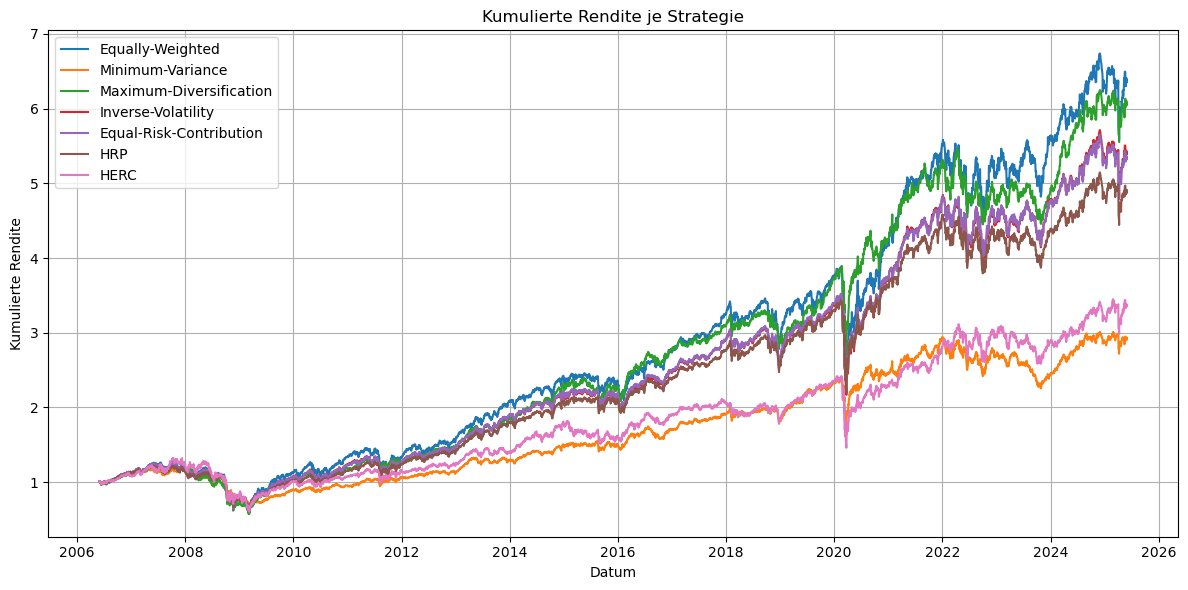

In [61]:
df_SP500_shrinked["Date"] = pd.to_datetime(df_SP500_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_shrinked = df_SP500_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sharpe_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [63]:
sharpe_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          1.981530          2.767749                 2.039013   
2007          0.405490          0.261648                 0.324007   
2008         -0.691100         -1.227213                -1.114251   
2009          1.173692          0.882959                 1.497204   
2010          1.001687          0.753215                 1.230363   
2011          0.090470          0.861964                 0.446790   
2012          1.293090          0.734159                 1.548596   
2013          2.596267          1.651838                 2.438438   
2014          1.200152          1.498886                 1.926880   
2015         -0.093203          0.131818                 0.024938   
2016          1.254461          1.287674                 1.729756   
2017          2.473111          2.045300                 1.602021   
2018         -0.568210         -0.234191                -0.410152   
2019          2.113257          2.783235                 2.488406   
2020          0.498540          0.314102                 0.588769   
2021          2.084777          1.679655                 1.888264   
2022         -0.245728         -0.485612                -0.508939   
2023          0.777059         -0.882138                 0.286277   
2024          1.092344          1.961501                 2.192447   
2025          0.260105          0.401725                 0.371379   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.216552                 2.247713  2.347480  1.452864  
2007            0.331335                 0.344988  0.258669  0.888603  
2008           -0.775651                -0.801710 -0.865933 -0.718571  
2009            1.171717                 1.175069  1.157923  0.823339  
2010            0.938614                 0.946488  0.930159  0.561189  
2011            0.215288                 0.270800  0.477792  0.469644  
2012            1.245974                 1.263491  1.270818  0.767565  
2013            2.555283                 2.584213  2.559566  1.244336  
2014            1.240491                 1.316420  1.340072  1.958375  
2015           -0.013965                -0.008406  0.134961 -0.518880  
2016            1.145365                 1.162167  1.165596  1.415635  
2017            2.509256                 2.503534  2.455260  1.351848  
2018           -0.529266                -0.492541 -0.364352 -0.785974  
2019            2.207325                 2.319572  2.442912  2.708331  
2020            0.471946                 0.463462  0.468310  0.112637  
2021            2.105133                 2.212495  2.126777  1.696953  
2022           -0.255051                -0.228521 -0.289469  0.358950  
2023            0.577035                 0.493075  0.284243 -0.156161  
2024            1.120763                 1.128345  1.079640  1.061534  
2025            0.289180                 0.248972  0.312976  0.738828

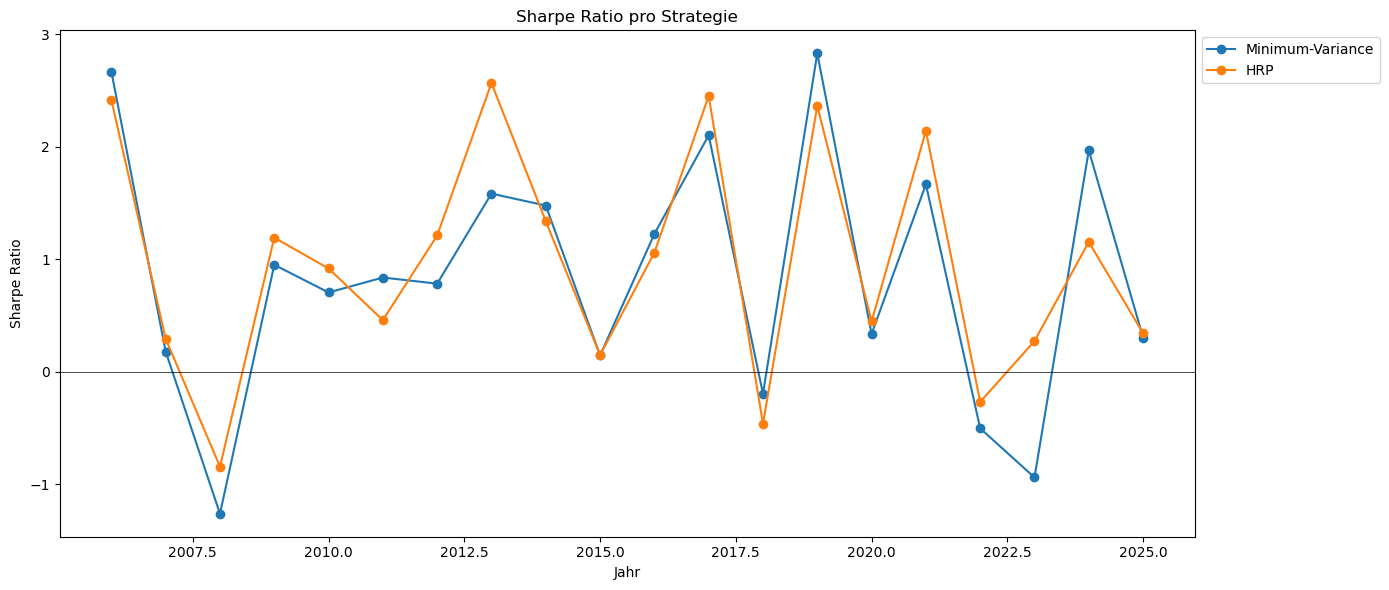

In [64]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [65]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_annual)

print(gesamt_sharpe_shrinked)

Equally-Weighted           0.573037
Minimum-Variance           0.476201
Maximum-Diversification    0.653049
Inverse-Volatility         0.561344
Equal-Risk-Contribution    0.568339
HRP                        0.575996
HERC                       0.429913
dtype: float64


#### Sortino Ratio

In [66]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sortino_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.269566          4.702033                 3.368185   
2007          0.542054          0.352631                 0.428991   
2008         -0.957707         -1.689582                -1.489254   
2009          1.747049          1.268363                 2.196453   
2010          1.455255          1.060992                 1.732589   
2011          0.122904          1.215537                 0.598790   
2012          1.971896          1.024547                 2.444404   
2013          3.940403          2.379254                 3.607964   
2014          1.680983          2.248863                 2.977078   
2015         -0.129305          0.179876                 0.034372   
2016          1.802213          1.863951                 2.653727   
2017          3.913458          3.128333                 2.313233   
2018         -0.731796         -0.308643                -0.537950   
2019          3.044574          4.299027                 3.566206   
2020          0.687535          0.436681                 0.815365   
2021          3.109933          2.439850                 2.843429   
2022         -0.347543         -0.651011                -0.687802   
2023          1.143862         -1.167992                 0.405647   
2024          1.576149          2.944090                 3.467392   
2025          0.378274          0.572412                 0.533616   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.694284                 3.766475  3.948627  2.219087  
2007            0.441815                 0.458918  0.344387  1.205841  
2008           -1.076809                -1.110993 -1.204715 -1.028787  
2009            1.724293                 1.727993  1.691470  1.166805  
2010            1.358581                 1.367742  1.337001  0.807146  
2011            0.292944                 0.368736  0.652698  0.644527  
2012            1.889018                 1.916607  1.922245  1.151799  
2013            3.904174                 3.932571  3.902724  1.825940  
2014            1.745501                 1.864362  1.905844  2.984501  
2015           -0.019397                -0.011678  0.188323 -0.682740  
2016            1.641304                 1.670071  1.679154  2.004208  
2017            3.985839                 3.961819  3.852987  1.997624  
2018           -0.681075                -0.634095 -0.470318 -1.009775  
2019            3.193995                 3.382154  3.602582  4.198365  
2020            0.648338                 0.634043  0.637449  0.151083  
2021            3.123583                 3.298860  3.161561  2.500269  
2022           -0.360127                -0.321470 -0.403221  0.512655  
2023            0.836114                 0.712872  0.406455 -0.215408  
2024            1.617208                 1.634665  1.551426  1.496259  
2025            0.417344                 0.358176  0.448876  1.060082

In [67]:

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_shrinked = df_SP500_shrinked.apply(sortino_annual)

print(gesamt_sortino_shrinked)

Equally-Weighted           0.809622
Minimum-Variance           0.665887
Maximum-Diversification    0.912232
Inverse-Volatility         0.789787
Equal-Risk-Contribution    0.798576
HRP                        0.807502
HERC                       0.602964
dtype: float64


In [68]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.052979         -0.030845                -0.042942   
2007         -0.099265         -0.069221                -0.092781   
2008         -0.483344         -0.358733                -0.473864   
2009         -0.310347         -0.157041                -0.228602   
2010         -0.153293         -0.072737                -0.128810   
2011         -0.216279         -0.093122                -0.129446   
2012         -0.098626         -0.043491                -0.052502   
2013         -0.056744         -0.069929                -0.058811   
2014         -0.070468         -0.045428                -0.046512   
2015         -0.124375         -0.091199                -0.152940   
2016         -0.088312         -0.097952                -0.072103   
2017         -0.033195         -0.029138                -0.033184   
2018         -0.195360         -0.114693                -0.149618   
2019         -0.064935         -0.038716                -0.045136   
2020         -0.388963         -0.320343                -0.310999   
2021         -0.054654         -0.078239                -0.070019   
2022         -0.186833         -0.177424                -0.185353   
2023         -0.135492         -0.177846                -0.117725   
2024         -0.076224         -0.052816                -0.053929   
2025         -0.148637         -0.095705                -0.110117   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.045822                -0.046477 -0.039115 -0.044422  
2007           -0.095911                -0.094029 -0.093773 -0.095210  
2008           -0.452272                -0.450550 -0.414395 -0.447805  
2009           -0.277552                -0.273236 -0.243890 -0.311018  
2010           -0.134874                -0.127690 -0.108642 -0.095879  
2011           -0.184403                -0.173602 -0.147362 -0.160914  
2012           -0.078864                -0.073211 -0.057843 -0.060882  
2013           -0.056992                -0.056991 -0.058250 -0.075133  
2014           -0.065509                -0.061965 -0.057056 -0.085582  
2015           -0.112053                -0.112762 -0.102212 -0.166998  
2016           -0.077399                -0.074888 -0.067028 -0.085835  
2017           -0.029441                -0.026475 -0.025742 -0.038881  
2018           -0.184584                -0.177076 -0.167069 -0.134371  
2019           -0.057919                -0.051746 -0.044839 -0.029148  
2020           -0.378719                -0.371699 -0.360483 -0.395459  
2021           -0.049877                -0.051478 -0.055262 -0.056731  
2022           -0.178763                -0.168198 -0.170800 -0.162475  
2023           -0.131475                -0.126112 -0.124107 -0.163622  
2024           -0.075603                -0.073530 -0.069613 -0.075699  
2025           -0.134895                -0.130948 -0.120374 -0.134422

In [69]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_total_shrinked = df_SP500_shrinked.apply(maximum_drawdown)

max_drawdown_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.541637
Minimum-Variance          -0.435356
Maximum-Diversification   -0.536861
Inverse-Volatility        -0.517481
Equal-Risk-Contribution   -0.516937
HRP                       -0.488828
HERC                      -0.543215
dtype: float64>

#### Calmar Ratio

In [70]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.457012          3.985178                 2.709006   
2007          0.550462          0.345585                 0.387187   
2008         -0.680668         -0.883614                -0.789221   
2009          1.301125          0.834877                 1.742300   
2010          1.227556          1.072532                 1.336250   
2011         -0.037833          1.194600                 0.493954   
2012          1.780566          1.279205                 3.082030   
2013          6.107092          2.278057                 4.573774   
2014          1.967770          2.966351                 4.770498   
2015         -0.205545          0.095156                -0.049262   
2016          2.001029          1.404078                 3.115186   
2017          5.571806          4.291077                 3.480270   
2018         -0.465415         -0.285629                -0.381529   
2019          4.266189          7.009315                 6.340896   
2020          0.318954          0.156626                 0.444025   
2021          5.603046          2.480075                 3.511138   
2022         -0.390778         -0.484291                -0.560479   
2023          0.726617         -0.521035                 0.221123   
2024          1.555801          3.335959                 4.176437   
2025          0.091404          0.222492                 0.183991   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.891543                 2.872978  3.241191  1.900583  
2007            0.423019                 0.448632  0.289944  1.574565  
2008           -0.714309                -0.719690 -0.746023 -0.754969  
2009            1.201882                 1.204757  1.116466  0.686739  
2010            1.163510                 1.189507  1.221598  0.755666  
2011            0.126317                 0.205379  0.506361  0.462339  
2012            1.868400                 1.980541  2.190628  1.110775  
2013            5.632068                 5.561010  5.099283  1.954754  
2014            2.108308                 2.333805  2.462533  2.939770  
2015           -0.116385                -0.106944  0.089046 -0.572235  
2016            1.909074                 1.969335  2.072592  2.156040  
2017            5.982404                 6.394426  6.265525  2.387805  
2018           -0.446507                -0.421526 -0.333432 -0.781554  
2019            4.682535                 5.191715  6.006202  9.312429  
2020            0.293020                 0.285742  0.293912 -0.058344  
2021            5.678072                 5.418858  4.576967  3.915203  
2022           -0.388126                -0.366959 -0.399415  0.311286  
2023            0.502818                 0.421182  0.209008 -0.170860  
2024            1.547017                 1.534955  1.475944  1.451967  
2025            0.117509                 0.093630  0.141854  0.416372

In [71]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_total_2_shrinked = df_SP500_shrinked.apply(calmar_ratio_total)

calmar_total_2_shrinked.info

<bound method Series.info of Equally-Weighted           9.926670
Minimum-Variance           4.434406
Maximum-Diversification    9.487794
Inverse-Volatility         8.538269
Equal-Risk-Contribution    8.422699
HRP                        7.989170
HERC                       4.360995
dtype: float64>

##### Value at Risk

In [72]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.009914         -0.006333                -0.007851   
2007         -0.020665         -0.013261                -0.016564   
2008         -0.046281         -0.028846                -0.040523   
2009         -0.032482         -0.016444                -0.024952   
2010         -0.018698         -0.010890                -0.014539   
2011         -0.025708         -0.011192                -0.015840   
2012         -0.012795         -0.008446                -0.009871   
2013         -0.011531         -0.008471                -0.009681   
2014         -0.011924         -0.009192                -0.010925   
2015         -0.016243         -0.012858                -0.013842   
2016         -0.013888         -0.010953                -0.011567   
2017         -0.006463         -0.005718                -0.007148   
2018         -0.018846         -0.012567                -0.014459   
2019         -0.011538         -0.008330                -0.008872   
2020         -0.032745         -0.024147                -0.024250   
2021         -0.012681         -0.010381                -0.012039   
2022         -0.022099         -0.015575                -0.019832   
2023         -0.013564         -0.011697                -0.011128   
2024         -0.009840         -0.007674                -0.008127   
2025         -0.018388         -0.013667                -0.014826   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.008827                -0.008609 -0.007538 -0.009287  
2007           -0.020122                -0.019609 -0.018044 -0.019857  
2008           -0.042143                -0.041197 -0.039036 -0.041152  
2009           -0.027135                -0.027091 -0.023870 -0.029096  
2010           -0.017010                -0.016209 -0.014404 -0.014430  
2011           -0.022573                -0.021320 -0.017764 -0.016538  
2012           -0.011594                -0.011204 -0.010030 -0.009091  
2013           -0.010161                -0.009844 -0.009132 -0.010965  
2014           -0.011132                -0.011004 -0.010715 -0.011600  
2015           -0.015771                -0.015876 -0.014966 -0.016104  
2016           -0.013345                -0.013043 -0.011988 -0.013641  
2017           -0.005973                -0.005680 -0.005425 -0.007239  
2018           -0.017948                -0.016997 -0.016023 -0.013772  
2019           -0.010171                -0.010023 -0.009831 -0.008739  
2020           -0.030659                -0.029983 -0.028330 -0.028911  
2021           -0.012214                -0.011370 -0.011502 -0.012773  
2022           -0.020537                -0.020271 -0.018644 -0.017311  
2023           -0.013127                -0.012913 -0.012043 -0.015168  
2024           -0.009644                -0.009185 -0.009018 -0.009879  
2025           -0.017912                -0.017640 -0.016955 -0.016803

In [73]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_total_shrinked = df_SP500_shrinked.apply(value_at_risk_func)

var_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019127
Minimum-Variance          -0.012438
Maximum-Diversification   -0.014925
Inverse-Volatility        -0.017654
Equal-Risk-Contribution   -0.017056
HRP                       -0.015518
HERC                      -0.016314
dtype: float64>

In [74]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_shrinked = monthly_returns_shrinked.apply(value_at_risk_func)

monthly_var_shrinked.info

<bound method Series.info of Equally-Weighted          -0.072198
Minimum-Variance          -0.049315
Maximum-Diversification   -0.058530
Inverse-Volatility        -0.065871
Equal-Risk-Contribution   -0.064023
HRP                       -0.057961
HERC                      -0.063090
dtype: float64>

#### Expected Shortfall

In [75]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.012752         -0.008331                -0.010573   
2007         -0.026188         -0.017846                -0.021121   
2008         -0.067396         -0.041882                -0.057467   
2009         -0.048139         -0.021561                -0.036189   
2010         -0.027827         -0.016251                -0.021236   
2011         -0.037531         -0.018975                -0.027344   
2012         -0.017673         -0.011197                -0.012887   
2013         -0.016223         -0.013324                -0.013848   
2014         -0.017142         -0.011862                -0.014145   
2015         -0.021815         -0.018451                -0.022097   
2016         -0.020534         -0.014160                -0.015206   
2017         -0.009295         -0.007685                -0.010022   
2018         -0.024968         -0.018292                -0.019530   
2019         -0.018506         -0.012445                -0.015324   
2020         -0.060682         -0.047516                -0.047555   
2021         -0.018820         -0.015509                -0.017158   
2022         -0.029483         -0.022591                -0.026366   
2023         -0.016851         -0.014631                -0.014860   
2024         -0.015070         -0.011173                -0.012730   
2025         -0.031805         -0.021808                -0.023810   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.011507                -0.011375 -0.010117 -0.012278  
2007           -0.025163                -0.024663 -0.022792 -0.027310  
2008           -0.061218                -0.060265 -0.054063 -0.062423  
2009           -0.040392                -0.039796 -0.033484 -0.045009  
2010           -0.025238                -0.024238 -0.021838 -0.021537  
2011           -0.034211                -0.033003 -0.028783 -0.029521  
2012           -0.015664                -0.015159 -0.013183 -0.011350  
2013           -0.015198                -0.014915 -0.014364 -0.014977  
2014           -0.016389                -0.015968 -0.015135 -0.015805  
2015           -0.021136                -0.021018 -0.020211 -0.025475  
2016           -0.019053                -0.018574 -0.017153 -0.019063  
2017           -0.008749                -0.008497 -0.008353 -0.008909  
2018           -0.024176                -0.023246 -0.022364 -0.020661  
2019           -0.017384                -0.016118 -0.015094 -0.012663  
2020           -0.058920                -0.057421 -0.055434 -0.059524  
2021           -0.017749                -0.016533 -0.015778 -0.016954  
2022           -0.027580                -0.026727 -0.025475 -0.025147  
2023           -0.016221                -0.015668 -0.014904 -0.018046  
2024           -0.014255                -0.013538 -0.012653 -0.014718  
2025           -0.029702                -0.028665 -0.026144 -0.029965

In [76]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_total_shrinked = df_SP500_shrinked.apply(expected_shortfall)

es_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.031972
Minimum-Variance          -0.020912
Maximum-Diversification   -0.025612
Inverse-Volatility        -0.029333
Equal-Risk-Contribution   -0.028543
HRP                       -0.026081
HERC                      -0.029231
dtype: float64>

In [77]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_shrinked  = monthly_returns_shrinked.apply(expected_shortfall)

monthly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.103476
Minimum-Variance          -0.074001
Maximum-Diversification   -0.087040
Inverse-Volatility        -0.096380
Equal-Risk-Contribution   -0.094553
HRP                       -0.088319
HERC                      -0.103537
dtype: float64>

In [78]:
yearly_returns_shrinked = df_SP500_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_shrinked  = yearly_returns_shrinked.apply(expected_shortfall)

yearly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.328997
Minimum-Variance          -0.316982
Maximum-Diversification   -0.373984
Inverse-Volatility        -0.323062
Equal-Risk-Contribution   -0.324256
HRP                       -0.309148
HERC                      -0.338079
dtype: float64>

In [79]:
#Zusammenfassung der Metriken
Zusammenfassung_shrinked = pd.concat([gesamt_sharpe_shrinked, gesamt_sortino_shrinked, max_drawdown_total_shrinked, calmar_total_2_shrinked, monthly_var_shrinked, monthly_es_shrinked], axis=1)
Zusammenfassung_shrinked.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.573037  0.809622     -0.541637  9.926670 -0.072198   
Minimum-Variance         0.476201  0.665887     -0.435356  4.434406 -0.049315   
Maximum-Diversification  0.653049  0.912232     -0.536861  9.487794 -0.058530   
Inverse-Volatility       0.561344  0.789787     -0.517481  8.538269 -0.065871   
Equal-Risk-Contribution  0.568339  0.798576     -0.516937  8.422699 -0.064023   
HRP                      0.575996  0.807502     -0.488828  7.989170 -0.057961   
HERC                     0.429913  0.602964     -0.543215  4.360995 -0.063090   

                               ES  
Equally-Weighted        -0.103476  
Minimum-Variance        -0.074001  
Maximum-Diversification -0.087040  
Inverse-Volatility      -0.096380  
Equal-Risk-Contribution -0.094553  
HRP                     -0.088319  
HERC                    -0.103537  


## 2-Jahre Trainingsfenster S&P500

In [80]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre = pd.read_csv(
    'returnsreduziert_neu_2jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [81]:
df_SP500_2jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2007-06-01          0.003875          0.003615                 0.007307   
1     2007-06-04          0.000970         -0.001387                -0.000204   
2     2007-06-05         -0.006651         -0.006884                -0.007726   
3     2007-06-06         -0.009918         -0.007495                -0.005197   
4     2007-06-07         -0.020541         -0.013442                -0.015839   
...          ...               ...               ...                      ...   
4524  2025-05-23         -0.001840          0.001374                 0.000337   
4525  2025-05-27          0.017177          0.005399                 0.008534   
4526  2025-05-28         -0.009486         -0.006501                -0.005625   
4527  2025-05-29          0.004241          0.003068                 0.003080   
4528  2025-05-30          0.000440          0.007437                 0.005327

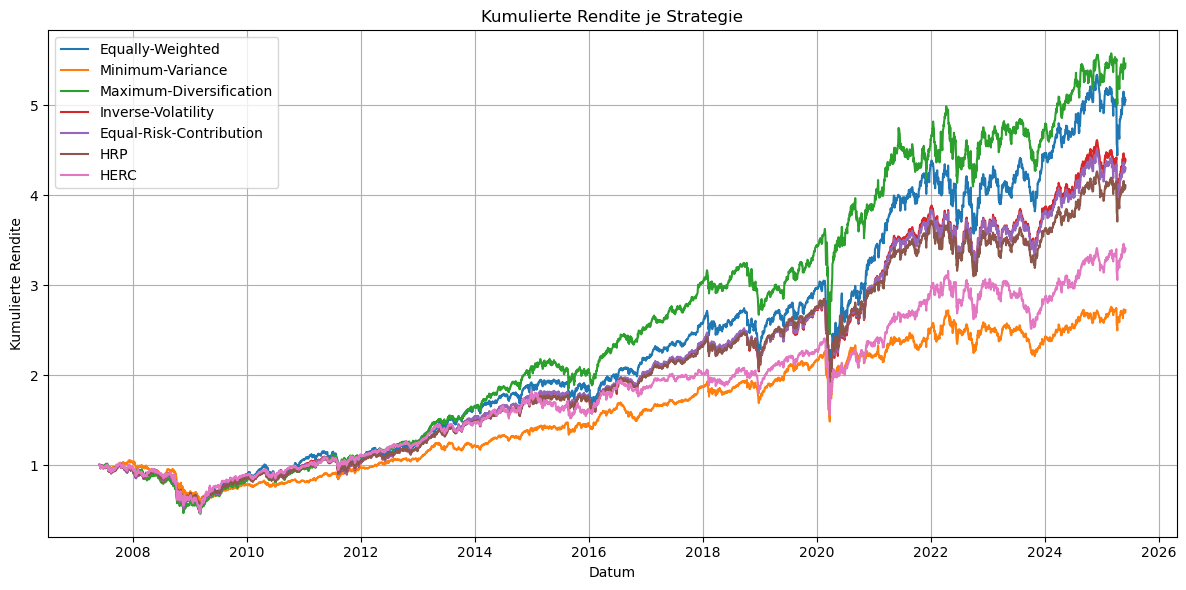

In [82]:
df_SP500_2jahre["Date"] = pd.to_datetime(df_SP500_2jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre = df_SP500_2jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sharpe_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.329850          0.433817                -0.404152   
2008         -0.698420         -1.231377                -1.117090   
2009          1.148836          0.803087                 1.545370   
2010          1.000815          0.561746                 1.071123   
2011          0.088466          1.364011                 0.793710   
2012          1.293090          1.033509                 1.415269   
2013          2.596267          1.576193                 2.775422   
2014          1.207062          1.489541                 2.067878   
2015         -0.040891          0.382526                 0.003283   
2016          1.181315          1.074083                 1.796704   
2017          2.520113          2.614038                 2.415135   
2018         -0.584440         -0.481954                -0.615500   
2019          2.072632          2.489979                 2.115271   
2020          0.488065          0.214728                 0.553396   
2021          2.084071          1.209951                 1.344253   
2022         -0.220342          0.058594                 0.053905   
2023          0.796860         -0.432879                 0.336509   
2024          1.084721          0.963444                 1.101970   
2025          0.279927          0.752326                 0.606422   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.344998                -0.370767 -0.344211 -0.118641  
2008           -0.772271                -0.795007 -0.840735 -0.772931  
2009            1.145883                 1.158764  1.142202  1.081471  
2010            0.973559                 0.970154  0.976341  0.782645  
2011            0.226491                 0.276645  0.441175  0.773145  
2012            1.245034                 1.254093  1.241672  1.144972  
2013            2.532728                 2.532264  2.457998  1.876909  
2014            1.289575                 1.367914  1.395636  1.361464  
2015            0.008418                 0.026637  0.169953 -0.468814  
2016            1.098424                 1.133625  1.109944  1.152426  
2017            2.518104                 2.526606  2.589241  1.342578  
2018           -0.520316                -0.518324 -0.343451 -0.538614  
2019            2.170439                 2.236872  2.347082  2.189253  
2020            0.442109                 0.428086  0.383741  0.271689  
2021            2.121212                 2.132658  2.084572  1.791091  
2022           -0.249088                -0.213313 -0.269316  0.187118  
2023            0.613081                 0.535950  0.405183 -0.340718  
2024            1.137921                 1.092801  1.136481  1.221187  
2025            0.335408                 0.345728  0.414971  0.918829

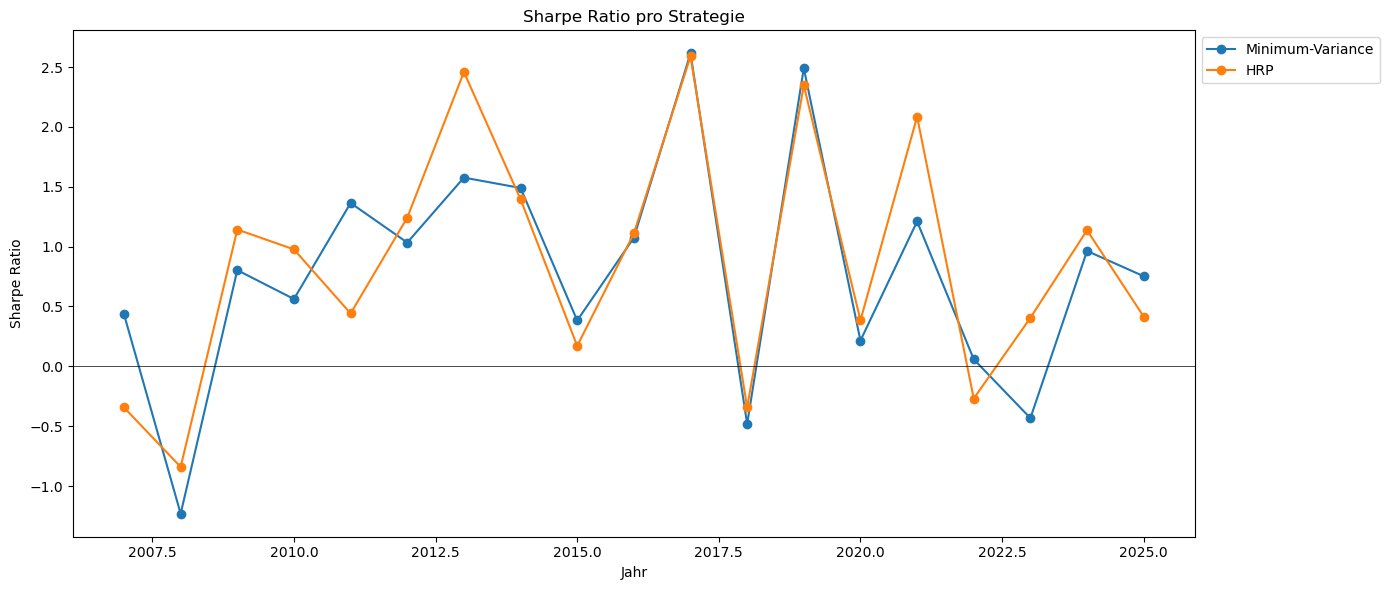

In [84]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre.columns
years = sharpe_jahresweise_2jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

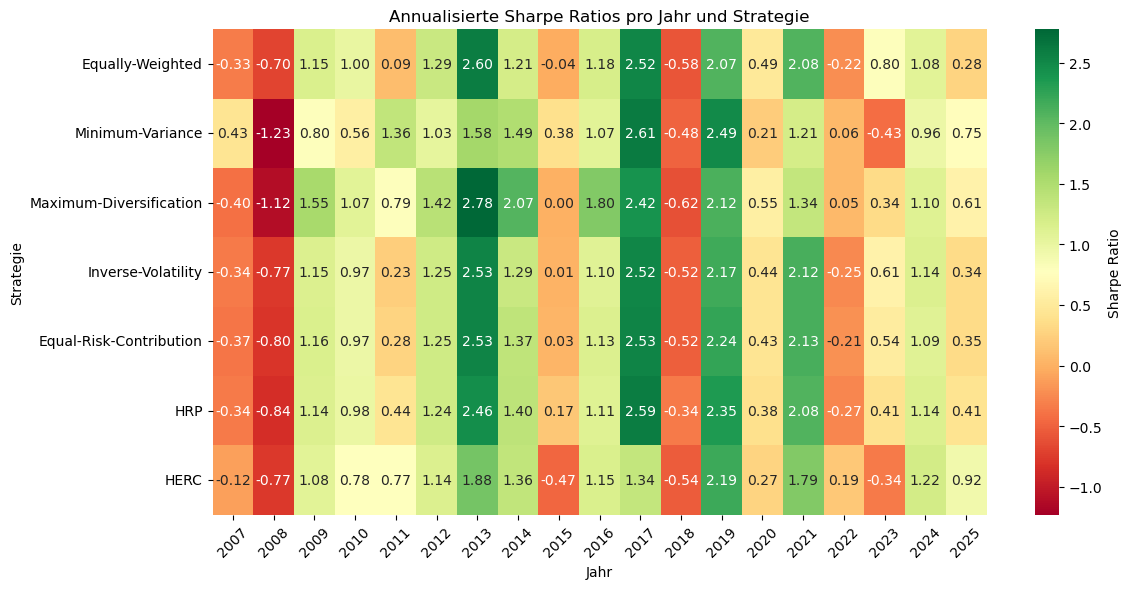

In [85]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_2jahre.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [86]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

gesamt_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre)

Equally-Weighted           0.531611
Minimum-Variance           0.457642
Maximum-Diversification    0.618699
Inverse-Volatility         0.520344
Equal-Risk-Contribution    0.521531
HRP                        0.534539
HERC                       0.447337
dtype: float64


In [87]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sortino_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.440112          0.606122                -0.533948   
2008         -0.964920         -1.694474                -1.470032   
2009          1.707865          1.146607                 2.298878   
2010          1.454860          0.790232                 1.520228   
2011          0.120170          1.982470                 1.085586   
2012          1.971896          1.494765                 2.225120   
2013          3.940403          2.320533                 4.217724   
2014          1.691765          2.242016                 3.208602   
2015         -0.056901          0.537427                 0.004631   
2016          1.691171          1.543239                 2.769947   
2017          3.984104          4.267167                 3.605523   
2018         -0.750765         -0.617111                -0.789825   
2019          2.984401          3.735852                 3.016519   
2020          0.673232          0.291872                 0.759469   
2021          3.106202          1.780865                 2.116295   
2022         -0.312108          0.079226                 0.074934   
2023          1.174038         -0.585224                 0.479124   
2024          1.564753          1.384770                 1.609356   
2025          0.406148          1.077822                 0.871577   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.460605                -0.492732 -0.459254 -0.160058  
2008           -1.069808                -1.098503 -1.167547 -1.070910  
2009            1.683973                 1.702835  1.667023  1.682480  
2010            1.409473                 1.402408  1.406386  1.136293  
2011            0.308294                 0.376725  0.601592  1.089749  
2012            1.889256                 1.902005  1.873197  1.768093  
2013            3.866646                 3.854011  3.734958  2.840814  
2014            1.822991                 1.947236  2.000282  1.991963  
2015            0.011717                 0.037117  0.238067 -0.622737  
2016            1.570379                 1.625746  1.596393  1.580317  
2017            4.015040                 4.026015  4.150311  1.985524  
2018           -0.668126                -0.665919 -0.442169 -0.700807  
2019            3.137166                 3.252477  3.458837  3.279388  
2020            0.607527                 0.585607  0.521680  0.371742  
2021            3.146067                 3.160920  3.068873  2.625039  
2022           -0.351813                -0.300383 -0.376109  0.267017  
2023            0.889938                 0.776540  0.581728 -0.463777  
2024            1.644769                 1.581920  1.648904  1.758415  
2025            0.484140                 0.498617  0.596345  1.329610

In [88]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre = df_SP500_2jahre.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre)

Equally-Weighted           0.749933
Minimum-Variance           0.637749
Maximum-Diversification    0.863100
Inverse-Volatility         0.731274
Equal-Risk-Contribution    0.731796
HRP                        0.748307
HERC                       0.635453
dtype: float64


In [89]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.097956         -0.059771                -0.096427   
2008         -0.482093         -0.357921                -0.512016   
2009         -0.311169         -0.162390                -0.233257   
2010         -0.158316         -0.084072                -0.136622   
2011         -0.216297         -0.081954                -0.130939   
2012         -0.098626         -0.034762                -0.045107   
2013         -0.056744         -0.072389                -0.043715   
2014         -0.068575         -0.045259                -0.046564   
2015         -0.121639         -0.093096                -0.148998   
2016         -0.089437         -0.121276                -0.068863   
2017         -0.032760         -0.031178                -0.033081   
2018         -0.196664         -0.132897                -0.177998   
2019         -0.066806         -0.046322                -0.052199   
2020         -0.387823         -0.344705                -0.322565   
2021         -0.054235         -0.080034                -0.118254   
2022         -0.185292         -0.174722                -0.178908   
2023         -0.134891         -0.142106                -0.118722   
2024         -0.076224         -0.054480                -0.061365   
2025         -0.146524         -0.095015                -0.101585   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.093972                -0.092194 -0.090436 -0.087923  
2008           -0.446569                -0.448224 -0.403412 -0.427569  
2009           -0.280057                -0.275770 -0.247680 -0.302495  
2010           -0.137144                -0.135040 -0.116317 -0.105822  
2011           -0.182282                -0.173336 -0.153061 -0.126994  
2012           -0.079297                -0.074340 -0.059144 -0.062551  
2013           -0.056842                -0.056344 -0.056640 -0.072304  
2014           -0.062449                -0.059727 -0.054791 -0.086921  
2015           -0.112574                -0.112331 -0.102760 -0.157560  
2016           -0.078284                -0.074431 -0.066967 -0.093347  
2017           -0.029290                -0.027142 -0.025235 -0.042226  
2018           -0.184280                -0.181509 -0.162847 -0.135617  
2019           -0.060459                -0.054879 -0.047870 -0.044443  
2020           -0.380422                -0.375223 -0.370455 -0.353116  
2021           -0.049239                -0.048849 -0.054269 -0.046541  
2022           -0.178439                -0.168271 -0.166546 -0.170284  
2023           -0.131379                -0.127850 -0.123762 -0.180785  
2024           -0.074689                -0.073379 -0.067638 -0.072994  
2025           -0.132641                -0.126820 -0.116313 -0.101005

In [90]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_total_2jahre = df_SP500_2jahre.apply(maximum_drawdown)

max_drawdown_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.542294
Minimum-Variance          -0.435796
Maximum-Diversification   -0.551416
Inverse-Volatility        -0.517880
Equal-Risk-Contribution   -0.516768
HRP                       -0.480944
HERC                      -0.546104
dtype: float64>

In [91]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.485651          0.494714                -0.475414   
2008         -0.683534         -0.890052                -0.774372   
2009          1.261408          0.699385                 1.861284   
2010          1.200836          0.676542                 1.212640   
2011         -0.039993          2.246853                 0.990459   
2012          1.780566          2.246743                 3.282126   
2013          6.107092          2.244592                 7.563642   
2014          2.018048          2.958021                 5.209652   
2015         -0.146440          0.444670                -0.076251   
2016          1.841334          0.925997                 3.353381   
2017          5.776174          5.222634                 6.147382   
2018         -0.472186         -0.469824                -0.468457   
2019          4.085742          5.195974                 4.690813   
2020          0.307902          0.055157                 0.397555   
2021          5.647473          1.748917                 1.599649   
2022         -0.364601         -0.021596                -0.052775   
2023          0.753767         -0.339351                 0.269890   
2024          1.544107          1.603970                 1.841833   
2025          0.105005          0.476072                 0.375189   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.503173                -0.527774 -0.470842 -0.270647  
2008           -0.717678                -0.719004 -0.746463 -0.793973  
2009            1.165032                 1.184889  1.103568  1.239108  
2010            1.194933                 1.191412  1.249559  1.055274  
2011            0.141854                 0.213056  0.445737  1.011657  
2012            1.863611                 1.947360  2.105168  1.610301  
2013            5.520612                 5.473473  4.972420  2.931712  
2014            2.270593                 2.490862  2.630470  2.115575  
2015           -0.087138                -0.062000  0.137824 -0.546202  
2016            1.808171                 1.934749  1.978099  1.679389  
2017            6.023154                 6.353102  6.847511  2.144366  
2018           -0.437649                -0.428238 -0.330205 -0.542034  
2019            4.446322                 4.789215  5.482434  4.958530  
2020            0.260426                 0.246997  0.202980  0.100898  
2021            5.775583                 5.570273  4.592871  5.174124  
2022           -0.381683                -0.352455 -0.391923  0.103249  
2023            0.542677                 0.461317  0.327125 -0.276643  
2024            1.577682                 1.483048  1.619593  1.728075  
2025            0.148953                 0.159960  0.216054  0.635252

In [92]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_total_2_2jahre = df_SP500_2jahre.apply(calmar_ratio_total)

calmar_total_2_2jahre.info

<bound method Series.info of Equally-Weighted           7.492339
Minimum-Variance           3.959042
Maximum-Diversification    8.100441
Inverse-Volatility         6.562044
Equal-Risk-Contribution    6.396609
HRP                        6.465380
HERC                       4.410369
dtype: float64>

In [93]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.022579         -0.014764                -0.020304   
2008         -0.045923         -0.030303                -0.044541   
2009         -0.032909         -0.015016                -0.026631   
2010         -0.019088         -0.011702                -0.015802   
2011         -0.025665         -0.011044                -0.016254   
2012         -0.012795         -0.008152                -0.009122   
2013         -0.011531         -0.009387                -0.010620   
2014         -0.011603         -0.008550                -0.010495   
2015         -0.016277         -0.012696                -0.015343   
2016         -0.013827         -0.010963                -0.010944   
2017         -0.006433         -0.005253                -0.008175   
2018         -0.018802         -0.013361                -0.016295   
2019         -0.011673         -0.009068                -0.009187   
2020         -0.032398         -0.024420                -0.025052   
2021         -0.012707         -0.011172                -0.012251   
2022         -0.021913         -0.016840                -0.021556   
2023         -0.013621         -0.011907                -0.011403   
2024         -0.009840         -0.009174                -0.010806   
2025         -0.018444         -0.012600                -0.013286   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.021811                -0.021412 -0.020050 -0.022174  
2008           -0.041026                -0.040757 -0.037936 -0.044498  
2009           -0.027443                -0.027219 -0.024550 -0.031692  
2010           -0.017039                -0.016886 -0.015240 -0.015032  
2011           -0.022119                -0.021085 -0.017799 -0.016029  
2012           -0.011639                -0.011292 -0.010021 -0.008434  
2013           -0.009984                -0.010067 -0.009300 -0.009319  
2014           -0.011126                -0.011053 -0.010773 -0.013725  
2015           -0.015606                -0.015789 -0.014924 -0.016495  
2016           -0.013021                -0.012789 -0.011927 -0.015373  
2017           -0.005984                -0.005845 -0.005656 -0.007078  
2018           -0.017735                -0.017044 -0.015660 -0.013187  
2019           -0.010367                -0.010139 -0.009935 -0.008454  
2020           -0.030634                -0.030296 -0.029294 -0.028201  
2021           -0.012121                -0.011961 -0.012043 -0.013332  
2022           -0.020173                -0.020001 -0.018819 -0.018959  
2023           -0.013229                -0.013162 -0.012733 -0.014133  
2024           -0.009549                -0.009416 -0.009063 -0.009854  
2025           -0.017950                -0.017433 -0.015985 -0.016627

In [94]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_total_2jahre = df_SP500_2jahre.apply(value_at_risk_func)

var_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.019448
Minimum-Variance          -0.012571
Maximum-Diversification   -0.015803
Inverse-Volatility        -0.017972
Equal-Risk-Contribution   -0.017477
HRP                       -0.015842
HERC                      -0.016584
dtype: float64>

In [95]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre = monthly_returns_2jahre.apply(value_at_risk_func)

monthly_var_2jahre.info

<bound method Series.info of Equally-Weighted          -0.073764
Minimum-Variance          -0.052672
Maximum-Diversification   -0.060031
Inverse-Volatility        -0.066668
Equal-Risk-Contribution   -0.066584
HRP                       -0.058450
HERC                      -0.061521
dtype: float64>

In [96]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.027417         -0.018320                -0.022188   
2008         -0.067189         -0.042265                -0.063751   
2009         -0.048285         -0.020908                -0.037004   
2010         -0.028068         -0.015928                -0.023330   
2011         -0.037499         -0.018317                -0.027087   
2012         -0.017673         -0.010510                -0.012851   
2013         -0.016223         -0.013415                -0.014333   
2014         -0.017024         -0.011674                -0.014215   
2015         -0.021839         -0.018128                -0.021267   
2016         -0.020568         -0.014246                -0.015598   
2017         -0.009350         -0.007141                -0.010484   
2018         -0.024946         -0.019964                -0.020559   
2019         -0.018658         -0.013015                -0.016314   
2020         -0.060456         -0.051150                -0.049218   
2021         -0.018855         -0.015237                -0.016747   
2022         -0.029320         -0.023427                -0.028220   
2023         -0.016915         -0.013829                -0.015068   
2024         -0.015057         -0.012744                -0.014006   
2025         -0.031692         -0.020894                -0.023461   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.026666                -0.025931 -0.024198 -0.027138  
2008           -0.060895                -0.060339 -0.053705 -0.065655  
2009           -0.040645                -0.040206 -0.034264 -0.048644  
2010           -0.025172                -0.024843 -0.022317 -0.022125  
2011           -0.033943                -0.032975 -0.029483 -0.025815  
2012           -0.015686                -0.015236 -0.013277 -0.010838  
2013           -0.015032                -0.014860 -0.014275 -0.014073  
2014           -0.016122                -0.015757 -0.014936 -0.017722  
2015           -0.021183                -0.020963 -0.020139 -0.024156  
2016           -0.019173                -0.018727 -0.017420 -0.021630  
2017           -0.008704                -0.008506 -0.008200 -0.008516  
2018           -0.024038                -0.023201 -0.022815 -0.020226  
2019           -0.017594                -0.016486 -0.015359 -0.013416  
2020           -0.059165                -0.057898 -0.056946 -0.054110  
2021           -0.017717                -0.016794 -0.015931 -0.017837  
2022           -0.027499                -0.026805 -0.025383 -0.025958  
2023           -0.016333                -0.015794 -0.015113 -0.017720  
2024           -0.014023                -0.013479 -0.012751 -0.014005  
2025           -0.029268                -0.028185 -0.025872 -0.024972

In [97]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_total_2jahre = df_SP500_2jahre.apply(expected_shortfall)

es_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.032517
Minimum-Variance          -0.021433
Maximum-Diversification   -0.027235
Inverse-Volatility        -0.029837
Equal-Risk-Contribution   -0.029184
HRP                       -0.026782
HERC                      -0.029316
dtype: float64>

In [98]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre  = monthly_returns_2jahre.apply(expected_shortfall)

monthly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.106435
Minimum-Variance          -0.080849
Maximum-Diversification   -0.096204
Inverse-Volatility        -0.098958
Equal-Risk-Contribution   -0.097465
HRP                       -0.090909
HERC                      -0.093233
dtype: float64>

In [99]:
yearly_returns_2jahre = df_SP500_2jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre  = yearly_returns_2jahre.apply(expected_shortfall)

yearly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.329527
Minimum-Variance          -0.318569
Maximum-Diversification   -0.396491
Inverse-Volatility        -0.320492
Equal-Risk-Contribution   -0.322275
HRP                       -0.301132
HERC                      -0.339478
dtype: float64>

In [100]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre = pd.concat([gesamt_sharpe_2jahre, gesamt_sortino_2jahre, max_drawdown_total_2jahre, calmar_total_2_2jahre, monthly_var_2jahre, monthly_es_2jahre], axis=1)
Zusammenfassung_2jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.531611  0.749933     -0.542294  7.492339 -0.073764   
Minimum-Variance         0.457642  0.637749     -0.435796  3.959042 -0.052672   
Maximum-Diversification  0.618699  0.863100     -0.551416  8.100441 -0.060031   
Inverse-Volatility       0.520344  0.731274     -0.517880  6.562044 -0.066668   
Equal-Risk-Contribution  0.521531  0.731796     -0.516768  6.396609 -0.066584   
HRP                      0.534539  0.748307     -0.480944  6.465380 -0.058450   
HERC                     0.447337  0.635453     -0.546104  4.410369 -0.061521   

                               ES  
Equally-Weighted        -0.106435  
Minimum-Variance        -0.080849  
Maximum-Diversification -0.096204  
Inverse-Volatility      -0.098958  
Equal-Risk-Contribution -0.097465  
HRP                     -0.090909  
HERC                    -0.093233  


## S&P 500 2Jahre Shrinked

In [101]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre_shrinked = pd.read_csv(
    'returnsreduziertshrinked_neu_2jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [102]:
df_SP500_2jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2007-06-01          0.003875          0.003513                 0.007082   
1     2007-06-04          0.000970         -0.001319                -0.000254   
2     2007-06-05         -0.006651         -0.007003                -0.007677   
3     2007-06-06         -0.009918         -0.007388                -0.005323   
4     2007-06-07         -0.020541         -0.013708                -0.015757   
...          ...               ...               ...                      ...   
4524  2025-05-23         -0.001840          0.001308                 0.000388   
4525  2025-05-27          0.017177          0.005663                 0.008793   
4526  2025-05-28         -0.009486         -0.006541                -0.006057   
4527  2025-05-29          0.004241          0.003121                 0.003252   
4528  2025-05-30          0.000440          0.007409                 0.005208

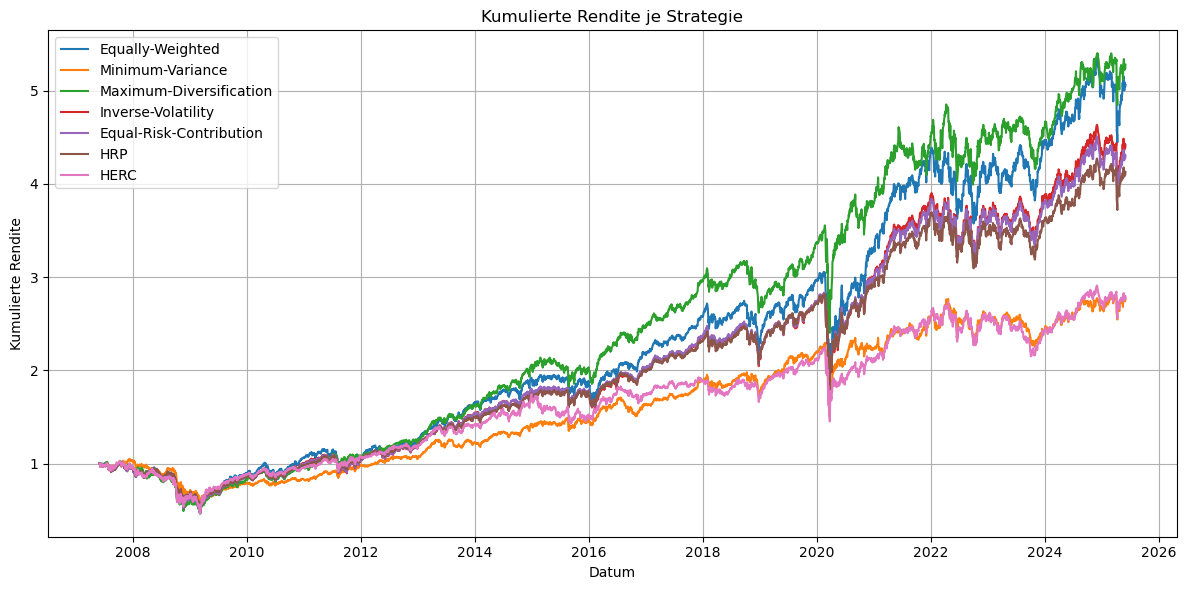

In [103]:
df_SP500_2jahre_shrinked["Date"] = pd.to_datetime(df_SP500_2jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre_shrinked = df_SP500_2jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [104]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sharpe_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.329850          0.345432                -0.375342   
2008         -0.698420         -1.186626                -1.132670   
2009          1.148836          0.783824                 1.499510   
2010          1.000815          0.581914                 1.092761   
2011          0.088466          1.357991                 0.786763   
2012          1.293090          1.006563                 1.413527   
2013          2.596267          1.588755                 2.759641   
2014          1.207062          1.531401                 2.064258   
2015         -0.040891          0.378709                 0.008653   
2016          1.181315          1.104593                 1.789194   
2017          2.520113          2.614067                 2.393976   
2018         -0.584440         -0.445941                -0.598639   
2019          2.072632          2.467058                 2.141036   
2020          0.488065          0.204453                 0.548354   
2021          2.084071          1.345645                 1.372153   
2022         -0.220342          0.028556                 0.042529   
2023          0.796860         -0.449041                 0.322609   
2024          1.084721          1.002168                 1.089274   
2025          0.279927          0.710301                 0.540882   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.347133                -0.370602 -0.326030 -0.186918  
2008           -0.769211                -0.796151 -0.825344 -0.723464  
2009            1.145230                 1.159260  1.144001  1.008071  
2010            0.975666                 0.969713  0.967995  0.641144  
2011            0.223521                 0.276976  0.451889  0.789344  
2012            1.246351                 1.253135  1.217271  1.004770  
2013            2.535379                 2.536998  2.442505  1.889065  
2014            1.286924                 1.367732  1.404218  1.328652  
2015            0.006819                 0.026544  0.160010 -0.578612  
2016            1.099811                 1.134538  1.108972  1.136289  
2017            2.519680                 2.526817  2.530407  1.302349  
2018           -0.524748                -0.518607 -0.373174 -0.656298  
2019            2.165915                 2.228232  2.272823  2.275775  
2020            0.445714                 0.428673  0.389363  0.165744  
2021            2.119680                 2.131919  2.134559  1.628418  
2022           -0.248289                -0.213838 -0.241104  0.009460  
2023            0.617100                 0.535254  0.416236 -0.337849  
2024            1.136301                 1.095776  1.145483  1.275610  
2025            0.331823                 0.346187  0.458827  0.393376

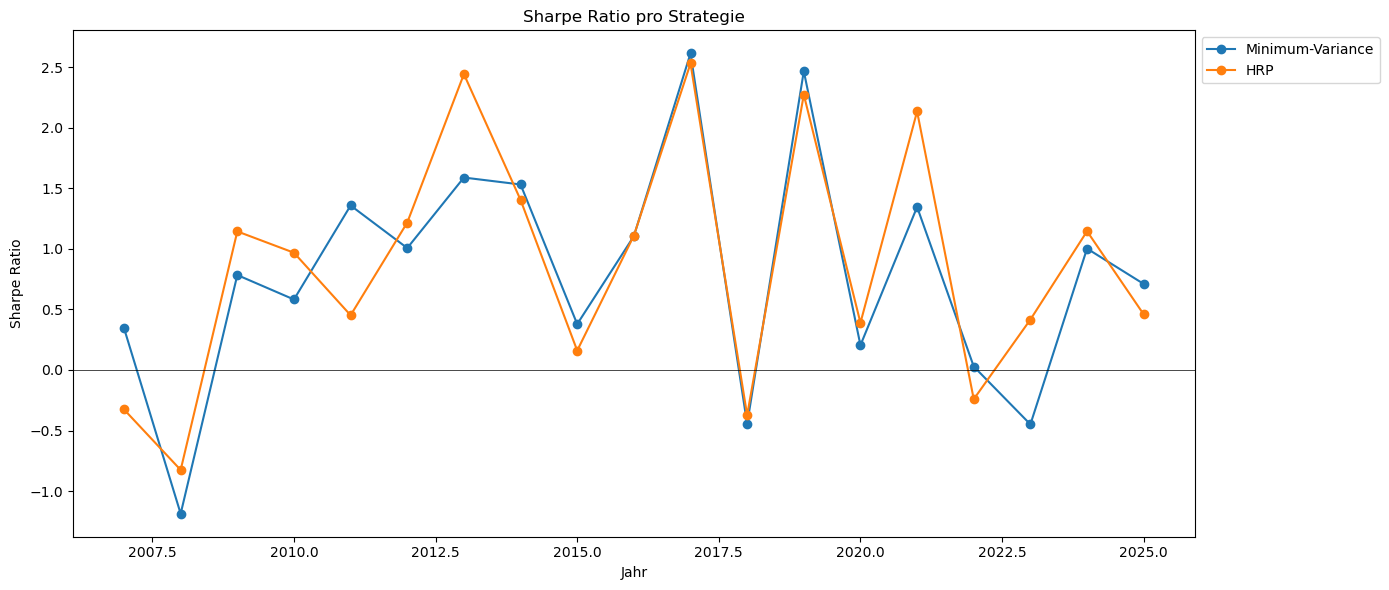

In [105]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre_shrinked.columns
years = sharpe_jahresweise_2jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [106]:
gesamt_sharpe_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre_shrinked)

Equally-Weighted           0.531611
Minimum-Variance           0.464974
Maximum-Diversification    0.617394
Inverse-Volatility         0.520193
Equal-Risk-Contribution    0.521370
HRP                        0.535946
HERC                       0.391968
dtype: float64


In [107]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sortino_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.440112          0.479539                -0.496571   
2008         -0.964920         -1.640767                -1.499454   
2009          1.707865          1.113010                 2.221281   
2010          1.454860          0.818676                 1.550723   
2011          0.120170          1.968944                 1.076277   
2012          1.971896          1.453991                 2.216665   
2013          3.940403          2.336038                 4.178294   
2014          1.691765          2.311005                 3.204879   
2015         -0.056901          0.532160                 0.012201   
2016          1.691171          1.588013                 2.755663   
2017          3.984104          4.266320                 3.572471   
2018         -0.750765         -0.571534                -0.768420   
2019          2.984401          3.704004                 3.059850   
2020          0.673232          0.277357                 0.751671   
2021          3.106202          1.989686                 2.140724   
2022         -0.312108          0.038645                 0.059069   
2023          1.174038         -0.608021                 0.458772   
2024          1.564753          1.445141                 1.590345   
2025          0.406148          1.015744                 0.775064   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.463346                -0.492161 -0.435347 -0.246497  
2008           -1.065380                -1.100014 -1.147899 -1.020309  
2009            1.683531                 1.703633  1.669571  1.560549  
2010            1.412852                 1.401734  1.392194  0.913962  
2011            0.304232                 0.377177  0.616384  1.119285  
2012            1.891415                 1.900360  1.841858  1.546856  
2013            3.870031                 3.862366  3.719168  2.862784  
2014            1.818721                 1.946948  2.013029  1.924375  
2015            0.009491                 0.036988  0.224137 -0.761656  
2016            1.572350                 1.626863  1.596862  1.557940  
2017            4.017164                 4.026337  4.020177  1.928086  
2018           -0.673819                -0.666274 -0.479735 -0.847388  
2019            3.129870                 3.239527  3.333714  3.417821  
2020            0.612688                 0.586422  0.528126  0.225277  
2021            3.144553                 3.159561  3.163625  2.368041  
2022           -0.350733                -0.301185 -0.337041  0.013270  
2023            0.896033                 0.775651  0.597838 -0.463756  
2024            1.642468                 1.586741  1.656647  1.843594  
2025            0.479116                 0.499298  0.659404  0.550572

In [108]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre_shrinked)

Equally-Weighted           0.749933
Minimum-Variance           0.648106
Maximum-Diversification    0.861950
Inverse-Volatility         0.731150
Equal-Risk-Contribution    0.731557
HRP                        0.750212
HERC                       0.556081
dtype: float64


In [109]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.097956         -0.060882                -0.092588   
2008         -0.482093         -0.347732                -0.488340   
2009         -0.311169         -0.163155                -0.225481   
2010         -0.158316         -0.085530                -0.134683   
2011         -0.216297         -0.082274                -0.129385   
2012         -0.098626         -0.035063                -0.044613   
2013         -0.056744         -0.071798                -0.044318   
2014         -0.068575         -0.044440                -0.045825   
2015         -0.121639         -0.093296                -0.146975   
2016         -0.089437         -0.118001                -0.068636   
2017         -0.032760         -0.031207                -0.032933   
2018         -0.196664         -0.133143                -0.175240   
2019         -0.066806         -0.046062                -0.049782   
2020         -0.387823         -0.345829                -0.324151   
2021         -0.054235         -0.078973                -0.111811   
2022         -0.185292         -0.172489                -0.177437   
2023         -0.134891         -0.141851                -0.118651   
2024         -0.076224         -0.052766                -0.061266   
2025         -0.146524         -0.095978                -0.102592   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.094233                -0.093021 -0.089798 -0.091022  
2008           -0.449386                -0.448598 -0.404833 -0.433471  
2009           -0.281536                -0.275799 -0.248104 -0.319272  
2010           -0.137998                -0.135072 -0.117061 -0.101372  
2011           -0.183089                -0.173364 -0.152371 -0.125827  
2012           -0.079755                -0.074693 -0.060298 -0.063774  
2013           -0.056809                -0.056343 -0.056984 -0.072304  
2014           -0.062650                -0.059739 -0.055841 -0.087150  
2015           -0.112796                -0.112339 -0.103142 -0.170467  
2016           -0.078558                -0.074437 -0.066084 -0.099432  
2017           -0.029415                -0.027145 -0.025562 -0.043904  
2018           -0.185070                -0.181537 -0.166590 -0.128207  
2019           -0.060710                -0.054888 -0.047761 -0.041145  
2020           -0.380610                -0.375237 -0.372891 -0.353271  
2021           -0.049375                -0.048855 -0.053247 -0.058711  
2022           -0.178803                -0.167747 -0.162894 -0.169959  
2023           -0.131436                -0.127772 -0.121514 -0.178606  
2024           -0.074823                -0.073379 -0.068146 -0.072882  
2025           -0.133303                -0.126817 -0.117042 -0.100716

In [110]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_2jahre_shrinked

Equally-Weighted          -0.542294
Minimum-Variance          -0.428289
Maximum-Diversification   -0.541286
Inverse-Volatility        -0.519497
Equal-Risk-Contribution   -0.517028
HRP                       -0.479411
HERC                      -0.551143
dtype: float64

In [111]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.485651          0.367608                -0.457198   
2008         -0.683534         -0.887772                -0.791649   
2009          1.261408          0.678215                 1.762384   
2010          1.200836          0.692159                 1.225764   
2011         -0.039993          2.226099                 0.979956   
2012          1.780566          2.157784                 3.257009   
2013          6.107092          2.281516                 7.304922   
2014          2.018048          3.099651                 5.214917   
2015         -0.146440          0.438322                -0.070561   
2016          1.841334          0.975052                 3.329798   
2017          5.776174          5.221466                 6.064869   
2018         -0.472186         -0.437412                -0.460729   
2019          4.085742          5.165477                 4.917908   
2020          0.307902          0.045927                 0.390044   
2021          5.647473          1.963002                 1.674473   
2022         -0.364601         -0.049552                -0.063147   
2023          0.753767         -0.349700                 0.255573   
2024          1.544107          1.717705                 1.800615   
2025          0.105005          0.443531                 0.323709   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.505468                -0.524395 -0.454720 -0.386771  
2008           -0.715408                -0.719224 -0.737090 -0.735361  
2009            1.167011                 1.185805  1.105568  1.056486  
2010            1.196322                 1.190697  1.232766  0.815894  
2011            0.137539                 0.213455  0.461012  1.047771  
2012            1.861073                 1.937919  2.020034  1.390437  
2013            5.539993                 5.487142  4.908608  2.961728  
2014            2.261517                 2.490141  2.600236  2.050694  
2015           -0.089174                -0.062121  0.123347 -0.606128  
2016            1.807190                 1.936513  1.993248  1.552074  
2017            6.015551                 6.353157  6.544560  2.022257  
2018           -0.439974                -0.428403 -0.345598 -0.685417  
2019            4.429851                 4.769583  5.282782  5.717669  
2020            0.264263                 0.247614  0.207113  0.001423  
2021            5.781758                 5.569158  4.815619  3.651209  
2022           -0.381156                -0.354271 -0.368495 -0.085417  
2023            0.547213                 0.461116  0.344770 -0.279183  
2024            1.575238                 1.488176  1.619505  1.736361  
2025            0.146225                 0.160267  0.245384  0.225156

In [112]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_total_2_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted           7.492339
Minimum-Variance           4.137066
Maximum-Diversification    7.908930
Inverse-Volatility         6.573561
Equal-Risk-Contribution    6.391589
HRP                        6.523977
HERC                       3.252992
dtype: float64>

In [113]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.022579         -0.015267                -0.019936   
2008         -0.045923         -0.029641                -0.043476   
2009         -0.032909         -0.015428                -0.025450   
2010         -0.019088         -0.011586                -0.015263   
2011         -0.025665         -0.011122                -0.016054   
2012         -0.012795         -0.008028                -0.009019   
2013         -0.011531         -0.009454                -0.010460   
2014         -0.011603         -0.008305                -0.010281   
2015         -0.016277         -0.012747                -0.015091   
2016         -0.013827         -0.010987                -0.010999   
2017         -0.006433         -0.005174                -0.008158   
2018         -0.018802         -0.013506                -0.016259   
2019         -0.011673         -0.009015                -0.009200   
2020         -0.032398         -0.024388                -0.025081   
2021         -0.012707         -0.010966                -0.012255   
2022         -0.021913         -0.016584                -0.021378   
2023         -0.013621         -0.011808                -0.011384   
2024         -0.009840         -0.009188                -0.010834   
2025         -0.018444         -0.012585                -0.013381   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.021874                -0.021414 -0.019948 -0.025092  
2008           -0.041384                -0.040761 -0.037881 -0.040892  
2009           -0.027632                -0.027217 -0.023531 -0.030540  
2010           -0.017132                -0.016889 -0.015242 -0.014071  
2011           -0.022204                -0.021088 -0.017871 -0.016015  
2012           -0.011676                -0.011293 -0.009980 -0.008426  
2013           -0.010010                -0.010066 -0.009345 -0.009164  
2014           -0.011113                -0.011053 -0.010516 -0.014330  
2015           -0.015622                -0.015789 -0.015044 -0.015900  
2016           -0.013035                -0.012789 -0.011902 -0.015169  
2017           -0.005984                -0.005845 -0.005629 -0.006998  
2018           -0.017788                -0.017046 -0.015625 -0.012791  
2019           -0.010406                -0.010140 -0.010208 -0.009494  
2020           -0.030661                -0.030297 -0.029424 -0.027012  
2021           -0.012144                -0.011961 -0.011590 -0.012923  
2022           -0.020197                -0.020005 -0.018653 -0.018152  
2023           -0.013230                -0.013175 -0.012552 -0.014035  
2024           -0.009573                -0.009417 -0.009135 -0.009796  
2025           -0.017969                -0.017435 -0.016290 -0.017204

In [114]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(value_at_risk_func)

var_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019448
Minimum-Variance          -0.012577
Maximum-Diversification   -0.015535
Inverse-Volatility        -0.018012
Equal-Risk-Contribution   -0.017480
HRP                       -0.015792
HERC                      -0.016501
dtype: float64>

In [115]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre_shrinked = monthly_returns_2jahre_shrinked.apply(value_at_risk_func)

monthly_var_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.073764
Minimum-Variance          -0.051827
Maximum-Diversification   -0.058658
Inverse-Volatility        -0.067004
Equal-Risk-Contribution   -0.066582
HRP                       -0.060680
HERC                      -0.061582
dtype: float64>

In [116]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.027417         -0.018480                -0.021850   
2008         -0.067189         -0.041709                -0.060663   
2009         -0.048285         -0.021140                -0.035577   
2010         -0.028068         -0.016060                -0.022736   
2011         -0.037499         -0.018434                -0.026724   
2012         -0.017673         -0.010487                -0.012653   
2013         -0.016223         -0.013475                -0.014236   
2014         -0.017024         -0.011646                -0.014071   
2015         -0.021839         -0.018150                -0.021164   
2016         -0.020568         -0.014139                -0.015534   
2017         -0.009350         -0.007160                -0.010406   
2018         -0.024946         -0.019920                -0.020477   
2019         -0.018658         -0.012977                -0.016126   
2020         -0.060456         -0.051228                -0.049222   
2021         -0.018855         -0.014933                -0.016332   
2022         -0.029320         -0.023237                -0.027771   
2023         -0.016915         -0.013727                -0.015024   
2024         -0.015057         -0.012630                -0.013842   
2025         -0.031692         -0.021064                -0.023528   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2007           -0.026724                -0.026029 -0.024201 -0.030442  
2008           -0.061288                -0.060355 -0.053855 -0.061974  
2009           -0.040967                -0.040219 -0.034367 -0.049502  
2010           -0.025288                -0.024848 -0.022414 -0.020842  
2011           -0.034029                -0.032978 -0.029306 -0.025691  
2012           -0.015733                -0.015248 -0.013231 -0.010852  
2013           -0.015064                -0.014867 -0.014157 -0.014113  
2014           -0.016148                -0.015758 -0.014922 -0.017941  
2015           -0.021200                -0.020964 -0.020169 -0.024819  
2016           -0.019206                -0.018734 -0.017210 -0.021451  
2017           -0.008722                -0.008506 -0.008204 -0.008498  
2018           -0.024088                -0.023204 -0.022747 -0.020285  
2019           -0.017642                -0.016487 -0.015470 -0.013575  
2020           -0.059229                -0.057908 -0.056890 -0.053999  
2021           -0.017776                -0.016798 -0.015900 -0.017974  
2022           -0.027563                -0.026808 -0.025330 -0.025356  
2023           -0.016344                -0.015803 -0.015123 -0.017150  
2024           -0.014055                -0.013481 -0.012794 -0.013505  
2025           -0.029420                -0.028184 -0.026069 -0.024849

In [117]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(expected_shortfall)

es_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.032517
Minimum-Variance          -0.021390
Maximum-Diversification   -0.026587
Inverse-Volatility        -0.029956
Equal-Risk-Contribution   -0.029195
HRP                       -0.026793
HERC                      -0.029042
dtype: float64>

In [118]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre_shrinked  = monthly_returns_2jahre_shrinked.apply(expected_shortfall)

monthly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.106435
Minimum-Variance          -0.079971
Maximum-Diversification   -0.093678
Inverse-Volatility        -0.099341
Equal-Risk-Contribution   -0.097474
HRP                       -0.091390
HERC                      -0.092651
dtype: float64>

In [119]:
yearly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre_shrinked  = yearly_returns_2jahre_shrinked.apply(expected_shortfall)

yearly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.329527
Minimum-Variance          -0.308707
Maximum-Diversification   -0.386594
Inverse-Volatility        -0.321494
Equal-Risk-Contribution   -0.322642
HRP                       -0.298398
HERC                      -0.318757
dtype: float64>

In [120]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre_shrinked = pd.concat([gesamt_sharpe_2jahre_shrinked, gesamt_sortino_2jahre_shrinked, max_drawdown_total_2jahre_shrinked, calmar_total_2_2jahre_shrinked, monthly_var_2jahre_shrinked, monthly_es_2jahre_shrinked], axis=1)
Zusammenfassung_2jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.531611  0.749933     -0.542294  7.492339 -0.073764   
Minimum-Variance         0.464974  0.648106     -0.428289  4.137066 -0.051827   
Maximum-Diversification  0.617394  0.861950     -0.541286  7.908930 -0.058658   
Inverse-Volatility       0.520193  0.731150     -0.519497  6.573561 -0.067004   
Equal-Risk-Contribution  0.521370  0.731557     -0.517028  6.391589 -0.066582   
HRP                      0.535946  0.750212     -0.479411  6.523977 -0.060680   
HERC                     0.391968  0.556081     -0.551143  3.252992 -0.061582   

                               ES  
Equally-Weighted        -0.106435  
Minimum-Variance        -0.079971  
Maximum-Diversification -0.093678  
Inverse-Volatility      -0.099341  
Equal-Risk-Contribution -0.097474  
HRP                     -0.091390  
HERC                    -0.092651  


## S&P500 3 Jahre

In [121]:
#Bearbeitete SP500-Daten (Gesamtbestand, 3 Jahre)

df_SP500_3jahre = pd.read_csv(
    'returnsreduziert_neu_3jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [122]:
df_SP500_3jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2008-06-02         -0.011709         -0.011521                -0.011595   
1     2008-06-03         -0.005032         -0.003744                 0.000518   
2     2008-06-04          0.001275          0.003026                 0.004573   
3     2008-06-05          0.014737          0.006326                 0.013822   
4     2008-06-06         -0.033311         -0.026738                -0.029048   
...          ...               ...               ...                      ...   
4272  2025-05-23         -0.001840          0.000053                -0.000024   
4273  2025-05-27          0.017177          0.006422                 0.008765   
4274  2025-05-28         -0.009486         -0.007585                -0.005969   
4275  2025-05-29          0.004241          0.003273                 0.003322   
4276  2025-05-30          0.000440          0.006952                 0.004955

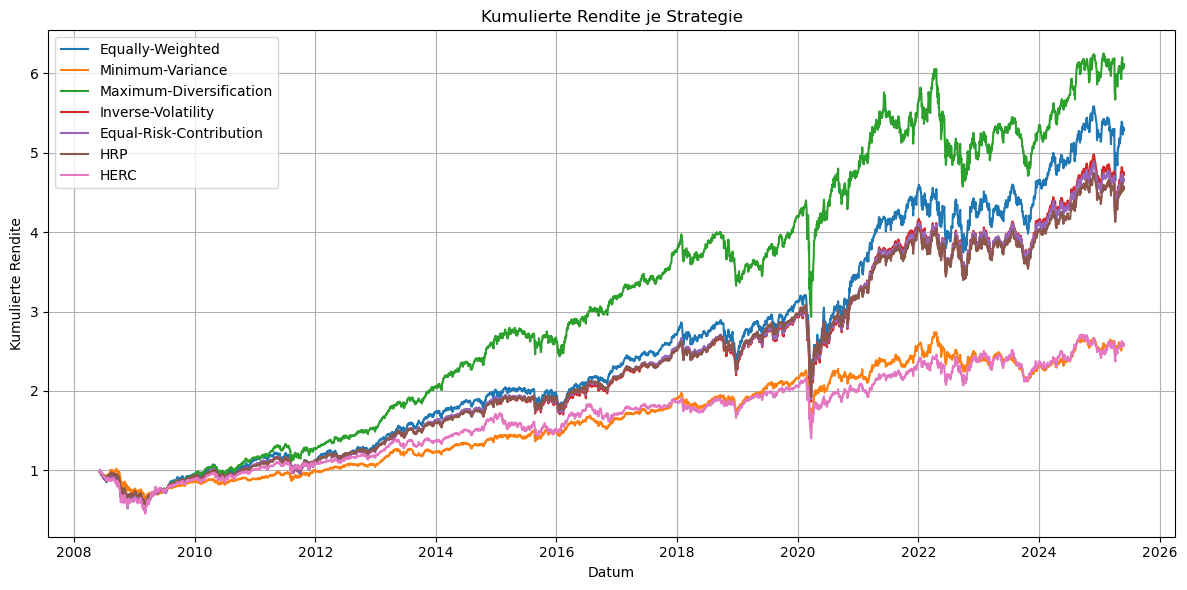

In [123]:
df_SP500_3jahre["Date"] = pd.to_datetime(df_SP500_3jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_3jahre = df_SP500_3jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_3jahre)

# Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [124]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
sharpe_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.973800         -1.192096                -1.336736   
2009          1.169245          0.867615                 1.578293   
2010          0.996396          0.495798                 1.415483   
2011          0.032979          0.830921                 0.580035   
2012          1.305028          0.730175                 1.798664   
2013          2.596267          1.658794                 2.958756   
2014          1.207062          1.447354                 2.277432   
2015         -0.027291          0.467790                 0.061924   
2016          1.167226          1.052639                 1.464889   
2017          2.525463          2.367335                 2.354482   
2018         -0.560358         -0.529340                -0.609201   
2019          2.034756          2.288852                 1.887013   
2020          0.469283          0.159239                 0.558261   
2021          2.101047          1.586943                 1.346297   
2022         -0.232972         -0.400604                -0.500810   
2023          0.774662         -0.263150                 0.620818   
2024          1.117956          1.022153                 1.198813   
2025          0.282940          0.532039                 0.556532   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -1.032807                -1.066905 -1.074485 -1.238891  
2009            1.159656                 1.180138  1.189309  1.027670  
2010            0.955880                 0.972859  0.971929  0.916655  
2011            0.199162                 0.221783  0.392483  0.528082  
2012            1.228108                 1.250599  1.223594  0.781647  
2013            2.527995                 2.530843  2.449869  1.589942  
2014            1.333028                 1.426349  1.552764  1.930978  
2015            0.019014                 0.047213  0.192531 -0.507811  
2016            1.123014                 1.124211  1.105436  0.902480  
2017            2.523979                 2.547483  2.442891  1.417855  
2018           -0.498336                -0.457541 -0.328614 -0.548959  
2019            2.122915                 2.151959  2.223237  2.028887  
2020            0.429612                 0.409099  0.395263  0.091323  
2021            2.133493                 2.147649  2.146351  1.349155  
2022           -0.254442                -0.230797 -0.250878  0.143809  
2023            0.648116                 0.610712  0.544032 -0.076063  
2024            1.167059                 1.118937  1.104409  0.721347  
2025            0.348428                 0.361612  0.475161  0.519381

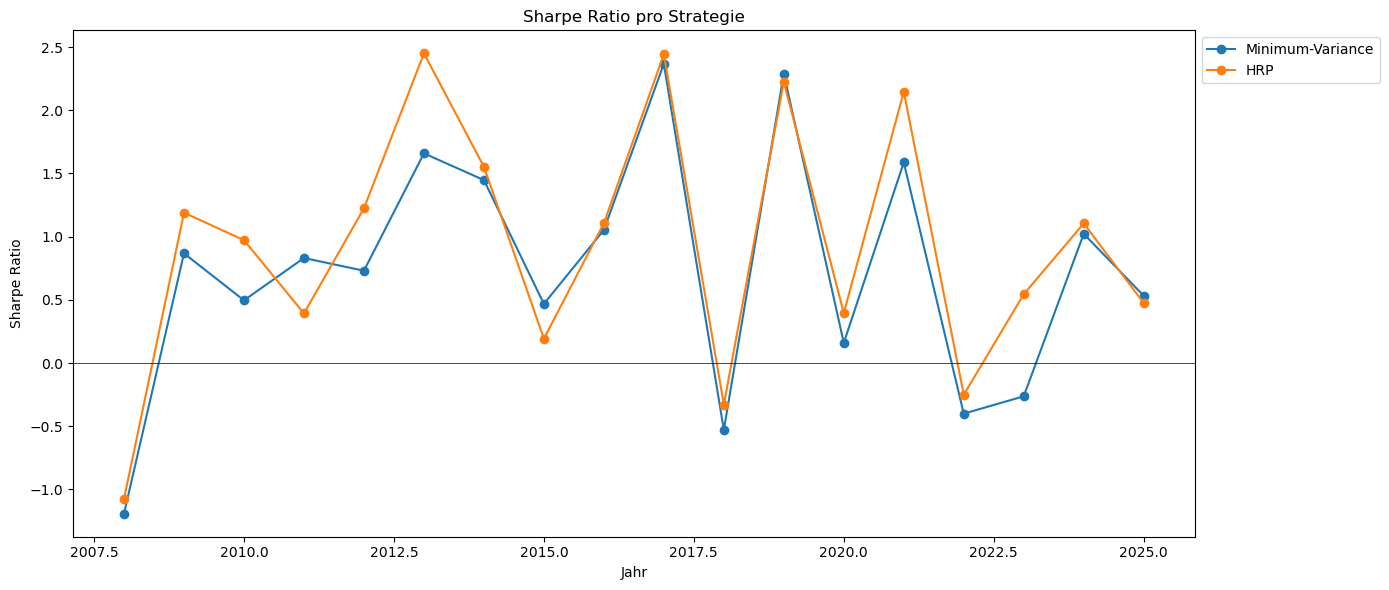

In [125]:
#Plotten der SR
strategien = sharpe_jahresweise_3jahre.columns
years = sharpe_jahresweise_3jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_3jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_3jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [126]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_3jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

gesamt_sharpe_3jahre = df_SP500_3jahre.apply(sharpe_annual_3jahre)

print(gesamt_sharpe_3jahre)

Equally-Weighted           0.567413
Minimum-Variance           0.456944
Maximum-Diversification    0.684374
Inverse-Volatility         0.566199
Equal-Risk-Contribution    0.569393
HRP                        0.593360
HERC                       0.379755
dtype: float64


In [127]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
sortino_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.334641         -1.684263                -1.784574   
2009          1.743375          1.235300                 2.349822   
2010          1.448861          0.694624                 2.039601   
2011          0.044702          1.160607                 0.795357   
2012          1.992265          1.031278                 2.862921   
2013          3.940403          2.453782                 4.449807   
2014          1.691765          2.176817                 3.571973   
2015         -0.037978          0.660744                 0.087527   
2016          1.670748          1.498045                 2.183202   
2017          3.998378          3.724136                 3.534195   
2018         -0.720694         -0.669656                -0.793696   
2019          2.931773          3.399280                 2.665622   
2020          0.646727          0.215177                 0.764564   
2021          3.136873          2.383495                 2.107571   
2022         -0.329643         -0.523292                -0.679399   
2023          1.138961         -0.364136                 0.906898   
2024          1.611766          1.505588                 1.798168   
2025          0.410548          0.726915                 0.796938   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -1.420235                -1.464116 -1.486348 -1.700556  
2009            1.707691                 1.737774  1.739154  1.590271  
2010            1.384367                 1.408201  1.402084  1.337642  
2011            0.270403                 0.301097  0.533377  0.732758  
2012            1.863618                 1.895986  1.850245  1.167917  
2013            3.856785                 3.852816  3.738801  2.367499  
2014            1.891123                 2.037999  2.248738  2.900624  
2015            0.026474                 0.065874  0.269677 -0.666176  
2016            1.607464                 1.611510  1.586923  1.217731  
2017            4.020117                 4.060065  3.869014  2.167238  
2018           -0.640153                -0.588946 -0.422954 -0.707133  
2019            3.065954                 3.117229  3.261248  2.985781  
2020            0.590389                 0.558996  0.537736  0.124074  
2021            3.169712                 3.186913  3.185293  1.967341  
2022           -0.359203                -0.324716 -0.351268  0.204000  
2023            0.943456                 0.889557  0.788201 -0.103718  
2024            1.685240                 1.614428  1.589915  1.057484  
2025            0.503162                 0.520932  0.680412  0.720594

In [128]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_3jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_3jahre = df_SP500_3jahre.apply(sortino_annual_3jahre)

print(gesamt_sortino_3jahre)

Equally-Weighted           0.800793
Minimum-Variance           0.635324
Maximum-Diversification    0.961280
Inverse-Volatility         0.796343
Equal-Risk-Contribution    0.799433
HRP                        0.831960
HERC                       0.539109
dtype: float64


In [129]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
max_drawdown_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.477133         -0.287988                -0.465486   
2009         -0.310027         -0.166235                -0.233788   
2010         -0.159392         -0.082618                -0.119242   
2011         -0.223403         -0.115886                -0.158766   
2012         -0.099074         -0.040726                -0.040279   
2013         -0.056744         -0.073643                -0.045222   
2014         -0.068575         -0.052952                -0.043137   
2015         -0.119745         -0.091272                -0.119594   
2016         -0.088503         -0.099755                -0.071383   
2017         -0.032456         -0.036540                -0.038038   
2018         -0.195461         -0.136651                -0.169439   
2019         -0.068601         -0.039208                -0.055624   
2020         -0.389544         -0.352056                -0.333184   
2021         -0.053533         -0.076517                -0.112028   
2022         -0.185938         -0.182290                -0.244426   
2023         -0.134588         -0.148408                -0.135982   
2024         -0.076720         -0.065125                -0.061086   
2025         -0.146524         -0.075769                -0.093495   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.444472                -0.445920 -0.404161 -0.470106  
2009           -0.281417                -0.275720 -0.245210 -0.310573  
2010           -0.140278                -0.137161 -0.120594 -0.124447  
2011           -0.183128                -0.178761 -0.156578 -0.127475  
2012           -0.080145                -0.075386 -0.060964 -0.062702  
2013           -0.056824                -0.056274 -0.056509 -0.081564  
2014           -0.059670                -0.055569 -0.049490 -0.050352  
2015           -0.111646                -0.110251 -0.102422 -0.166440  
2016           -0.076326                -0.073875 -0.067610 -0.121716  
2017           -0.029989                -0.027220 -0.028547 -0.035003  
2018           -0.181929                -0.175748 -0.167433 -0.131438  
2019           -0.062126                -0.057639 -0.051720 -0.039218  
2020           -0.382027                -0.376839 -0.373388 -0.350384  
2021           -0.049172                -0.048436 -0.051891 -0.081048  
2022           -0.178819                -0.169682 -0.163390 -0.158790  
2023           -0.131596                -0.128946 -0.121566 -0.158662  
2024           -0.075777                -0.075313 -0.072245 -0.082772  
2025           -0.131434                -0.124293 -0.114005 -0.096822

In [130]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
max_drawdown_total_3jahre = df_SP500_3jahre.apply(maximum_drawdown)

max_drawdown_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.508135
Minimum-Variance          -0.369426
Maximum-Diversification   -0.482861
Inverse-Volatility        -0.481658
Equal-Risk-Contribution   -0.479551
HRP                       -0.441538
HERC                      -0.545063
dtype: float64>

In [131]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
calmar_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.681853         -0.828467                -0.740552   
2009          1.297111          0.741265                 1.869557   
2010          1.190872          0.592602                 1.913759   
2011         -0.101824          1.010110                 0.607676   
2012          1.794094          1.340707                 4.796606   
2013          6.107092          2.380848                 8.058024   
2014          2.018048          2.567674                 6.489847   
2015         -0.131145          0.582919                -0.019869   
2016          1.851982          1.071348                 2.742454   
2017          5.836999          4.272006                 4.973732   
2018         -0.460368         -0.492096                -0.480118   
2019          3.935251          5.684769                 3.967852   
2020          0.286561          0.004336                 0.395696   
2021          5.757716          2.443253                 1.637748   
2022         -0.377053         -0.428670                -0.497173   
2023          0.729476         -0.206492                 0.481445   
2024          1.590926          1.424360                 1.997128   
2025          0.106922          0.378797                 0.361995   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.698745                -0.700114 -0.703096 -0.778662  
2009            1.184217                 1.214844  1.167466  1.272428  
2010            1.157606                 1.189960  1.222817  1.160878  
2011            0.107471                 0.138611  0.375472  0.632134  
2012            1.816588                 1.914189  2.020915  1.112724  
2013            5.518216                 5.490163  4.991866  2.208365  
2014            2.434563                 2.772922  3.213308  4.136027  
2015           -0.072856                -0.035102  0.169903 -0.579124  
2016            1.919662                 1.955489  1.960186  1.056609  
2017            5.960166                 6.429260  5.714154  2.716821  
2018           -0.428071                -0.399634 -0.313170 -0.567690  
2019            4.275077                 4.445794  4.926295  5.126232  
2020            0.246645                 0.226711  0.213163 -0.066019  
2021            5.859178                 5.693564  5.029787  2.046474  
2022           -0.389958                -0.371800 -0.388180  0.057511  
2023            0.575278                 0.529288  0.470482 -0.116284  
2024            1.603067                 1.489461  1.469406  0.904743  
2025            0.158492                 0.173437  0.259927  0.344077

In [132]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
calmar_total_2_3jahre = df_SP500_3jahre.apply(calmar_ratio_total)

calmar_total_2_3jahre.info

<bound method Series.info of Equally-Weighted            8.447796
Minimum-Variance            4.304797
Maximum-Diversification    10.590721
Inverse-Volatility          7.770929
Equal-Risk-Contribution     7.635060
HRP                         8.079837
HERC                        2.926056
dtype: float64>

In [133]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
var_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.059841         -0.033121                -0.054633   
2009         -0.031957         -0.014370                -0.025846   
2010         -0.019029         -0.012036                -0.014788   
2011         -0.026014         -0.011986                -0.017668   
2012         -0.012818         -0.008121                -0.009926   
2013         -0.011531         -0.008912                -0.010373   
2014         -0.011603         -0.008466                -0.010837   
2015         -0.016078         -0.012033                -0.016036   
2016         -0.013973         -0.010438                -0.013379   
2017         -0.006576         -0.005279                -0.007863   
2018         -0.018867         -0.013116                -0.014878   
2019         -0.011865         -0.009164                -0.010719   
2020         -0.032752         -0.023926                -0.025356   
2021         -0.012656         -0.011011                -0.012341   
2022         -0.022046         -0.017741                -0.021522   
2023         -0.013538         -0.010034                -0.011164   
2024         -0.009871         -0.008746                -0.010474   
2025         -0.018444         -0.012905                -0.013866   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.054062                -0.052525 -0.047889 -0.058413  
2009           -0.026924                -0.026842 -0.023594 -0.038667  
2010           -0.017268                -0.017040 -0.015457 -0.015018  
2011           -0.022369                -0.021848 -0.018708 -0.016467  
2012           -0.011597                -0.011307 -0.010138 -0.008718  
2013           -0.010057                -0.010053 -0.009478 -0.010130  
2014           -0.011119                -0.010818 -0.010193 -0.009647  
2015           -0.015598                -0.015711 -0.014692 -0.016072  
2016           -0.013370                -0.013342 -0.011994 -0.016510  
2017           -0.006205                -0.006105 -0.005799 -0.006203  
2018           -0.017810                -0.017283 -0.016228 -0.012744  
2019           -0.010550                -0.010179 -0.010016 -0.009378  
2020           -0.030846                -0.030417 -0.029663 -0.026033  
2021           -0.012334                -0.011942 -0.011673 -0.012611  
2022           -0.020841                -0.020498 -0.019429 -0.018927  
2023           -0.013214                -0.013121 -0.012530 -0.015415  
2024           -0.009638                -0.009522 -0.009030 -0.011063  
2025           -0.017729                -0.017405 -0.016674 -0.016785

In [134]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
var_total_3jahre = df_SP500_3jahre.apply(value_at_risk_func)

var_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.019233
Minimum-Variance          -0.012248
Maximum-Diversification   -0.015466
Inverse-Volatility        -0.017806
Equal-Risk-Contribution   -0.017219
HRP                       -0.015946
HERC                      -0.016446
dtype: float64>

In [135]:
monthly_returns_3jahre = df_SP500_3jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_3jahre = monthly_returns_3jahre.apply(value_at_risk_func)

monthly_var_3jahre.info

<bound method Series.info of Equally-Weighted          -0.077413
Minimum-Variance          -0.052053
Maximum-Diversification   -0.057319
Inverse-Volatility        -0.067419
Equal-Risk-Contribution   -0.067681
HRP                       -0.061106
HERC                      -0.060857
dtype: float64>

In [136]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
es_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_3jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.077029         -0.045648                -0.067611   
2009         -0.048028         -0.021120                -0.036301   
2010         -0.028182         -0.015910                -0.022808   
2011         -0.038066         -0.021531                -0.029152   
2012         -0.017654         -0.011006                -0.012686   
2013         -0.016223         -0.013833                -0.014830   
2014         -0.017024         -0.012029                -0.014385   
2015         -0.021776         -0.018524                -0.021179   
2016         -0.020745         -0.013997                -0.017353   
2017         -0.009279         -0.007982                -0.010009   
2018         -0.025003         -0.019674                -0.019740   
2019         -0.018813         -0.013194                -0.016628   
2020         -0.060761         -0.052117                -0.050249   
2021         -0.018723         -0.014642                -0.015978   
2022         -0.029398         -0.025469                -0.030563   
2023         -0.016892         -0.012929                -0.013947   
2024         -0.015189         -0.011452                -0.013457   
2025         -0.031692         -0.019945                -0.022308   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.070165                -0.069188 -0.061779 -0.075266  
2009           -0.040825                -0.040190 -0.034005 -0.058202  
2010           -0.025521                -0.025123 -0.022793 -0.023505  
2011           -0.033845                -0.033369 -0.029907 -0.026107  
2012           -0.015654                -0.015227 -0.013235 -0.011778  
2013           -0.015048                -0.014867 -0.014168 -0.014394  
2014           -0.015888                -0.015507 -0.014494 -0.014194  
2015           -0.021048                -0.020837 -0.020117 -0.025800  
2016           -0.019372                -0.018955 -0.017564 -0.022644  
2017           -0.008776                -0.008563 -0.008351 -0.008048  
2018           -0.024062                -0.023254 -0.023048 -0.020064  
2019           -0.017818                -0.016801 -0.015941 -0.013928  
2020           -0.059475                -0.058275 -0.057368 -0.054029  
2021           -0.017771                -0.016847 -0.016034 -0.016535  
2022           -0.027799                -0.027184 -0.026119 -0.026843  
2023           -0.016164                -0.015591 -0.014883 -0.018725  
2024           -0.014144                -0.013650 -0.012919 -0.014012  
2025           -0.029093                -0.028041 -0.025428 -0.024689

In [137]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
es_total_3jahre = df_SP500_3jahre.apply(expected_shortfall)

es_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.032886
Minimum-Variance          -0.021711
Maximum-Diversification   -0.027279
Inverse-Volatility        -0.030150
Equal-Risk-Contribution   -0.029501
HRP                       -0.027163
HERC                      -0.030192
dtype: float64>

In [138]:
monthly_returns_3jahre = df_SP500_3jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_3jahre = monthly_returns_3jahre.apply(expected_shortfall)

monthly_es_3jahre.info

<bound method Series.info of Equally-Weighted          -0.106826
Minimum-Variance          -0.078375
Maximum-Diversification   -0.091529
Inverse-Volatility        -0.099816
Equal-Risk-Contribution   -0.097704
HRP                       -0.092109
HERC                      -0.095148
dtype: float64>

In [139]:
yearly_returns_3jahre = df_SP500_3jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_3jahre  = yearly_returns_3jahre.apply(expected_shortfall)

yearly_es_3jahre.info

<bound method Series.info of Equally-Weighted          -0.325334
Minimum-Variance          -0.238588
Maximum-Diversification   -0.344717
Inverse-Volatility        -0.310573
Equal-Risk-Contribution   -0.312195
HRP                       -0.284164
HERC                      -0.366054
dtype: float64>

In [140]:
#Zusammenfassung der Metriken
Zusammenfassung_3jahre = pd.concat([gesamt_sharpe_3jahre, gesamt_sortino_3jahre, max_drawdown_total_3jahre, calmar_total_2_3jahre, monthly_var_3jahre, monthly_es_3jahre], axis=1)
Zusammenfassung_3jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_3jahre)

                           Sharpe   Sortino  Max Drawdown     Calmar  \
Equally-Weighted         0.567413  0.800793     -0.508135   8.447796   
Minimum-Variance         0.456944  0.635324     -0.369426   4.304797   
Maximum-Diversification  0.684374  0.961280     -0.482861  10.590721   
Inverse-Volatility       0.566199  0.796343     -0.481658   7.770929   
Equal-Risk-Contribution  0.569393  0.799433     -0.479551   7.635060   
HRP                      0.593360  0.831960     -0.441538   8.079837   
HERC                     0.379755  0.539109     -0.545063   2.926056   

                              Var        ES  
Equally-Weighted        -0.077413 -0.106826  
Minimum-Variance        -0.052053 -0.078375  
Maximum-Diversification -0.057319 -0.091529  
Inverse-Volatility      -0.067419 -0.099816  
Equal-Risk-Contribution -0.067681 -0.097704  
HRP                     -0.061106 -0.092109  
HERC                    -0.060857 -0.095148  


## S&P500 3 Jahre Shrinked

In [141]:
#Bearbeitete SP500-Daten (Gesamtbestand, 3 Jahre)

df_SP500_3jahre_shrinked = pd.read_csv(
    'returnsreduziertshrinked_neu_3jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [142]:
df_SP500_3jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2008-06-02         -0.011709         -0.011492                -0.011625   
1     2008-06-03         -0.005032         -0.003534                 0.000237   
2     2008-06-04          0.001275          0.003073                 0.004269   
3     2008-06-05          0.014737          0.006425                 0.013474   
4     2008-06-06         -0.033311         -0.026855                -0.028932   
...          ...               ...               ...                      ...   
4272  2025-05-23         -0.001840          0.000271                -0.000036   
4273  2025-05-27          0.017177          0.006558                 0.008822   
4274  2025-05-28         -0.009486         -0.007592                -0.006072   
4275  2025-05-29          0.004241          0.003383                 0.003379   
4276  2025-05-30          0.000440          0.006908                 0.004940

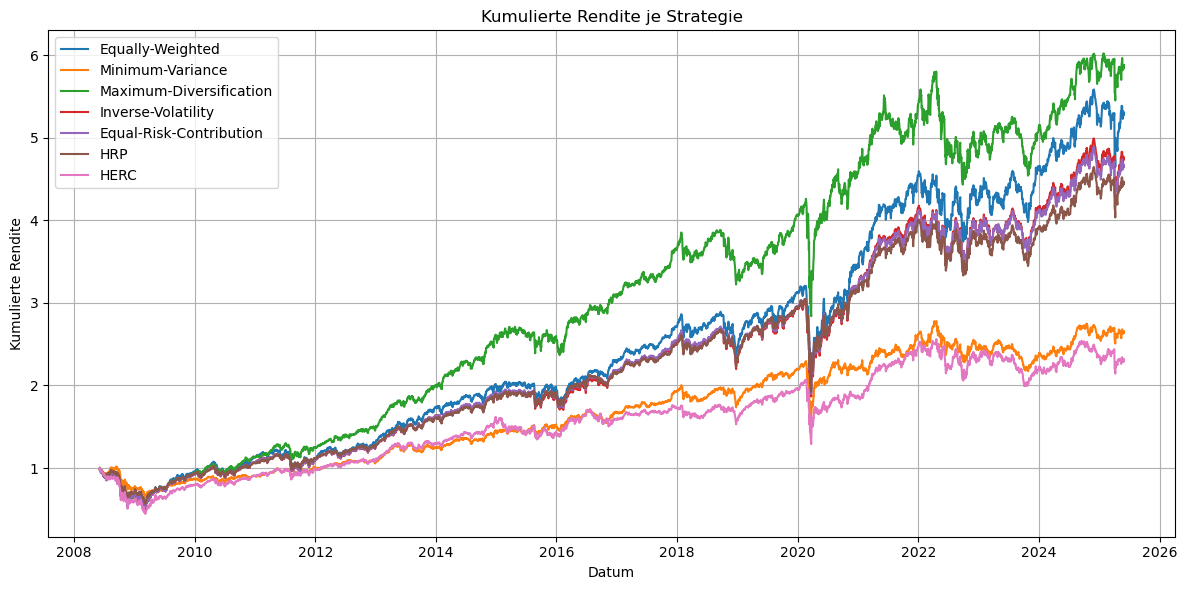

In [143]:
df_SP500_3jahre_shrinked["Date"] = pd.to_datetime(df_SP500_3jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_3jahre_shrinked = df_SP500_3jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_3jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
sharpe_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.973800         -1.135246                -1.365407   
2009          1.169245          0.844702                 1.549798   
2010          0.996396          0.513949                 1.390495   
2011          0.032979          0.829015                 0.589278   
2012          1.305028          0.746628                 1.781156   
2013          2.596267          1.675220                 2.940051   
2014          1.207062          1.470734                 2.277094   
2015         -0.027291          0.460572                 0.069986   
2016          1.167226          1.069148                 1.474888   
2017          2.525463          2.383253                 2.356184   
2018         -0.560358         -0.515997                -0.615935   
2019          2.034756          2.289492                 1.885956   
2020          0.469283          0.158378                 0.537396   
2021          2.101047          1.617007                 1.356745   
2022         -0.232972         -0.368085                -0.475945   
2023          0.774662         -0.260589                 0.580276   
2024          1.117956          1.029891                 1.211317   
2025          0.282940          0.542444                 0.519070   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -1.030459                -1.066782 -1.072883 -1.314265  
2009            1.159203                 1.179806  1.202451  0.915011  
2010            0.957821                 0.973120  0.939666  0.995585  
2011            0.193883                 0.221555  0.373170  0.583354  
2012            1.231442                 1.250731  1.247328  1.080301  
2013            2.530330                 2.530756  2.465101  1.743976  
2014            1.330290                 1.426192  1.512956  1.801477  
2015            0.017998                 0.055622  0.176646 -0.479707  
2016            1.123546                 1.122135  1.078473  0.823126  
2017            2.524324                 2.547400  2.498883  1.380627  
2018           -0.500191                -0.457575 -0.374783 -0.593138  
2019            2.119863                 2.143634  2.259788  2.289434  
2020            0.432409                 0.411833  0.382979  0.047478  
2021            2.131805                 2.144706  2.160323  2.274793  
2022           -0.254743                -0.229415 -0.290855 -0.207297  
2023            0.651304                 0.610800  0.480753 -0.358897  
2024            1.166455                 1.119002  1.168690  0.717260  
2025            0.347201                 0.362494  0.439500 -0.086772

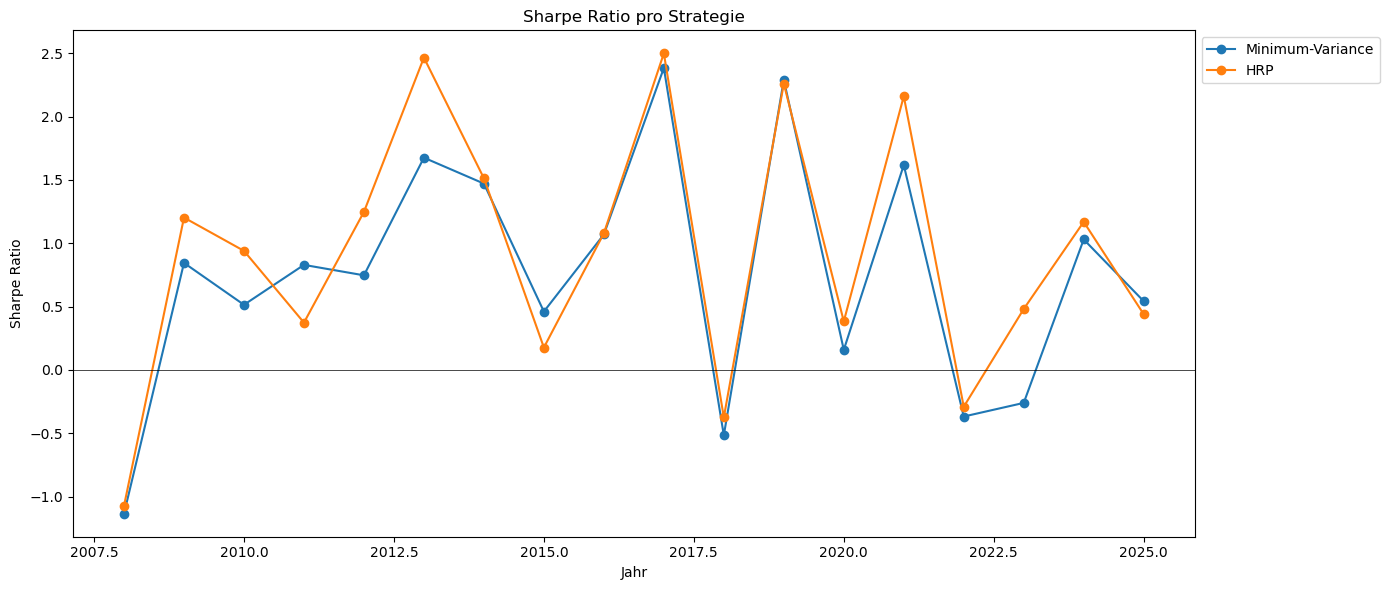

In [145]:
#Plotten der SR
strategien = sharpe_jahresweise_3jahre_shrinked.columns
years = sharpe_jahresweise_3jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_3jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_3jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [146]:
gesamt_sharpe_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(sharpe_annual_3jahre)

print(gesamt_sharpe_3jahre_shrinked)

Equally-Weighted           0.567413
Minimum-Variance           0.467591
Maximum-Diversification    0.680319
Inverse-Volatility         0.565828
Equal-Risk-Contribution    0.569727
HRP                        0.587096
HERC                       0.348841
dtype: float64


In [147]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
sortino_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -1.334641         -1.609440                -1.825472   
2009          1.743375          1.197573                 2.299839   
2010          1.448861          0.721614                 2.002038   
2011          0.044702          1.156325                 0.806804   
2012          1.992265          1.056646                 2.828183   
2013          3.940403          2.477588                 4.416506   
2014          1.691765          2.214893                 3.573700   
2015         -0.037978          0.650118                 0.098875   
2016          1.670748          1.523102                 2.198721   
2017          3.998378          3.760415                 3.542457   
2018         -0.720694         -0.653343                -0.801395   
2019          2.931773          3.402714                 2.661859   
2020          0.646727          0.213880                 0.735022   
2021          3.136873          2.431224                 2.111862   
2022         -0.329643         -0.481425                -0.645334   
2023          1.138961         -0.361136                 0.845672   
2024          1.611766          1.516431                 1.818004   
2025          0.410548          0.741062                 0.742303   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -1.416715                -1.463940 -1.481892 -1.783289  
2009            1.707645                 1.737282  1.762602  1.320516  
2010            1.387363                 1.408599  1.352693  1.441084  
2011            0.263217                 0.300785  0.507053  0.806651  
2012            1.869124                 1.896207  1.886802  1.660119  
2013            3.860067                 3.852550  3.756172  2.611319  
2014            1.886708                 2.037748  2.187239  2.674576  
2015            0.025060                 0.077632  0.247388 -0.630428  
2016            1.608203                 1.608716  1.548958  1.105686  
2017            4.020405                 4.059886  3.977254  2.099737  
2018           -0.642553                -0.588986 -0.481245 -0.765100  
2019            3.061098                 3.103960  3.322247  3.405229  
2020            0.594381                 0.562802  0.520268  0.064677  
2021            3.167797                 3.182549  3.200892  3.403702  
2022           -0.359658                -0.322788 -0.406515 -0.289353  
2023            0.948258                 0.889689  0.695766 -0.484236  
2024            1.684383                 1.614531  1.680861  1.053149  
2025            0.501458                 0.522139  0.629926 -0.117249

In [148]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(sortino_annual_3jahre)

print(gesamt_sortino_3jahre_shrinked)

Equally-Weighted           0.800793
Minimum-Variance           0.650410
Maximum-Diversification    0.954922
Inverse-Volatility         0.795896
Equal-Risk-Contribution    0.799926
HRP                        0.822632
HERC                       0.484763
dtype: float64


In [149]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
max_drawdown_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.477133         -0.279289                -0.449595   
2009         -0.310027         -0.166316                -0.228148   
2010         -0.159392         -0.083867                -0.116774   
2011         -0.223403         -0.115390                -0.154992   
2012         -0.099074         -0.040329                -0.039877   
2013         -0.056744         -0.072862                -0.045573   
2014         -0.068575         -0.052913                -0.042662   
2015         -0.119745         -0.091383                -0.118545   
2016         -0.088503         -0.098046                -0.070703   
2017         -0.032456         -0.035951                -0.037843   
2018         -0.195461         -0.134547                -0.170061   
2019         -0.068601         -0.039067                -0.054290   
2020         -0.389544         -0.352161                -0.333592   
2021         -0.053533         -0.075951                -0.108026   
2022         -0.185938         -0.179461                -0.236042   
2023         -0.134588         -0.148164                -0.135741   
2024         -0.076720         -0.064952                -0.061019   
2025         -0.146524         -0.076249                -0.094666   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.446710                -0.446021 -0.400910 -0.492448  
2009           -0.282742                -0.275784 -0.243050 -0.293717  
2010           -0.140913                -0.137187 -0.121451 -0.108709  
2011           -0.184483                -0.178808 -0.157237 -0.132757  
2012           -0.080497                -0.075398 -0.061500 -0.059118  
2013           -0.056809                -0.056274 -0.056574 -0.071967  
2014           -0.059855                -0.055576 -0.048562 -0.051859  
2015           -0.111779                -0.110190 -0.101969 -0.163162  
2016           -0.076531                -0.073878 -0.065334 -0.120863  
2017           -0.030049                -0.027220 -0.025358 -0.034841  
2018           -0.182339                -0.175761 -0.170089 -0.134705  
2019           -0.062317                -0.057637 -0.050124 -0.044542  
2020           -0.382187                -0.376876 -0.369107 -0.375919  
2021           -0.049346                -0.048437 -0.053785 -0.047280  
2022           -0.179252                -0.169512 -0.169277 -0.195939  
2023           -0.131652                -0.128951 -0.125267 -0.180658  
2024           -0.075821                -0.075312 -0.071912 -0.079977  
2025           -0.131723                -0.124252 -0.114198 -0.122538

In [150]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
max_drawdown_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_3jahre_shrinked

Equally-Weighted          -0.508135
Minimum-Variance          -0.361207
Maximum-Diversification   -0.476665
Inverse-Volatility        -0.483096
Equal-Risk-Contribution   -0.479621
HRP                       -0.437097
HERC                      -0.552550
dtype: float64

In [151]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
calmar_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.681853         -0.823339                -0.756737   
2009          1.297111          0.720908                 1.794879   
2010          1.190872          0.607255                 1.872413   
2011         -0.101824          1.001997                 0.623797   
2012          1.794094          1.383675                 4.728751   
2013          6.107092          2.432214                 7.881234   
2014          2.018048          2.605793                 6.491659   
2015         -0.131145          0.571211                -0.008939   
2016          1.851982          1.107427                 2.772795   
2017          5.836999          4.363017                 4.967135   
2018         -0.460368         -0.487733                -0.482761   
2019          3.935251          5.704155                 4.031899   
2020          0.286561          0.003734                 0.373128   
2021          5.757716          2.486976                 1.683563   
2022         -0.377053         -0.405291                -0.484575   
2023          0.729476         -0.204707                 0.443148   
2024          1.590926          1.434315                 2.013570   
2025          0.106922          0.386513                 0.328617   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.697482                -0.700073 -0.702290 -0.786816  
2009            1.186596                 1.214502  1.192791  0.990347  
2010            1.159319                 1.190258  1.166175  1.331644  
2011            0.100103                 0.138292  0.349437  0.683446  
2012            1.818796                 1.914293  2.051880  1.744097  
2013            5.531567                 5.489107  5.023008  2.774425  
2014            2.424718                 2.772308  3.187668  3.762534  
2015           -0.074189                -0.023946  0.148179 -0.561490  
2016            1.917608                 1.952222  1.967718  0.970496  
2017            5.956407                 6.429152  6.583954  2.664042  
2018           -0.428991                -0.399644 -0.344406 -0.593142  
2019            4.263429                 4.432909  5.166976  5.263033  
2020            0.249593                 0.229533  0.202854 -0.115175  
2021            5.852788                 5.684623  4.850182  6.537307  
2022           -0.390350                -0.370573 -0.416734 -0.306531  
2023            0.579158                 0.529390  0.394270 -0.295729  
2024            1.602849                 1.489622  1.572390  0.931823  
2025            0.157500                 0.174079  0.236570 -0.133512

In [152]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
calmar_total_2_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted            8.447796
Minimum-Variance            4.584132
Maximum-Diversification    10.241626
Inverse-Volatility          7.774940
Equal-Risk-Contribution     7.647083
HRP                         7.923071
HERC                        2.383038
dtype: float64>

In [153]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
var_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.059841         -0.033766                -0.052181   
2009         -0.031957         -0.014956                -0.024888   
2010         -0.019029         -0.011869                -0.014723   
2011         -0.026014         -0.011627                -0.017132   
2012         -0.012818         -0.008093                -0.009963   
2013         -0.011531         -0.008923                -0.010358   
2014         -0.011603         -0.008514                -0.010642   
2015         -0.016078         -0.012062                -0.015881   
2016         -0.013973         -0.010442                -0.013290   
2017         -0.006576         -0.005138                -0.007849   
2018         -0.018867         -0.013136                -0.014991   
2019         -0.011865         -0.009108                -0.010675   
2020         -0.032752         -0.024056                -0.025050   
2021         -0.012656         -0.010976                -0.012328   
2022         -0.022046         -0.017657                -0.021117   
2023         -0.013538         -0.010025                -0.010970   
2024         -0.009871         -0.008698                -0.010378   
2025         -0.018444         -0.012918                -0.013859   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.054344                -0.052540 -0.047165 -0.060948  
2009           -0.027031                -0.026856 -0.023725 -0.031431  
2010           -0.017328                -0.017040 -0.015337 -0.013819  
2011           -0.022494                -0.021853 -0.018541 -0.016648  
2012           -0.011626                -0.011308 -0.010130 -0.008579  
2013           -0.010082                -0.010052 -0.009400 -0.009690  
2014           -0.011127                -0.010819 -0.010500 -0.009917  
2015           -0.015583                -0.015711 -0.014998 -0.016150  
2016           -0.013386                -0.013343 -0.011762 -0.016730  
2017           -0.006204                -0.006105 -0.005729 -0.006514  
2018           -0.017835                -0.017283 -0.016338 -0.012674  
2019           -0.010591                -0.010178 -0.010109 -0.009332  
2020           -0.030868                -0.030561 -0.029750 -0.026854  
2021           -0.012333                -0.011941 -0.012042 -0.011688  
2022           -0.020928                -0.020501 -0.019570 -0.020546  
2023           -0.013214                -0.013121 -0.012506 -0.014880  
2024           -0.009652                -0.009522 -0.009142 -0.011062  
2025           -0.017743                -0.017408 -0.016689 -0.017022

In [154]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
var_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(value_at_risk_func)

var_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019233
Minimum-Variance          -0.012134
Maximum-Diversification   -0.015462
Inverse-Volatility        -0.017832
Equal-Risk-Contribution   -0.017220
HRP                       -0.015797
HERC                      -0.016824
dtype: float64>

In [155]:
monthly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_3jahre_shrinked = monthly_returns_3jahre_shrinked.apply(value_at_risk_func)

monthly_var_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.077413
Minimum-Variance          -0.051448
Maximum-Diversification   -0.055570
Inverse-Volatility        -0.068002
Equal-Risk-Contribution   -0.067693
HRP                       -0.061580
HERC                      -0.067398
dtype: float64>

In [161]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
es_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_3jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.077029         -0.045266                -0.065314   
2009         -0.048028         -0.021335                -0.035110   
2010         -0.028182         -0.015843                -0.022378   
2011         -0.038066         -0.021334                -0.028636   
2012         -0.017654         -0.010935                -0.012603   
2013         -0.016223         -0.013835                -0.014760   
2014         -0.017024         -0.012022                -0.014277   
2015         -0.021776         -0.018525                -0.021090   
2016         -0.020745         -0.013984                -0.017247   
2017         -0.009279         -0.007927                -0.009933   
2018         -0.025003         -0.019641                -0.019750   
2019         -0.018813         -0.013179                -0.016556   
2020         -0.060761         -0.052120                -0.050252   
2021         -0.018723         -0.014508                -0.015747   
2022         -0.029398         -0.025444                -0.029965   
2023         -0.016892         -0.012902                -0.013876   
2024         -0.015189         -0.011435                -0.013388   
2025         -0.031692         -0.019999                -0.022301   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2008           -0.070528                -0.069206 -0.061472 -0.077569  
2009           -0.041119                -0.040204 -0.033853 -0.051853  
2010           -0.025608                -0.025125 -0.022752 -0.021590  
2011           -0.033981                -0.033376 -0.029945 -0.025804  
2012           -0.015690                -0.015228 -0.013339 -0.011813  
2013           -0.015067                -0.014861 -0.014174 -0.014390  
2014           -0.015912                -0.015508 -0.014503 -0.014395  
2015           -0.021060                -0.020838 -0.020088 -0.025685  
2016           -0.019392                -0.018956 -0.017428 -0.023005  
2017           -0.008787                -0.008563 -0.008349 -0.008087  
2018           -0.024089                -0.023255 -0.023097 -0.020153  
2019           -0.017851                -0.016837 -0.015914 -0.014175  
2020           -0.059526                -0.058270 -0.056723 -0.057343  
2021           -0.017811                -0.016842 -0.015878 -0.016692  
2022           -0.027865                -0.027186 -0.026159 -0.027990  
2023           -0.016184                -0.015592 -0.014821 -0.017856  
2024           -0.014165                -0.013651 -0.012941 -0.014039  
2025           -0.029156                -0.028056 -0.025855 -0.030228

In [157]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
es_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(expected_shortfall)

es_total_3jahre_shrinked

Equally-Weighted          -0.032886
Minimum-Variance          -0.021663
Maximum-Diversification   -0.026770
Inverse-Volatility        -0.030256
Equal-Risk-Contribution   -0.029507
HRP                       -0.027080
HERC                      -0.030328
dtype: float64

In [158]:
monthly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_3jahre_shrinked = monthly_returns_3jahre_shrinked.apply(expected_shortfall)

monthly_es_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.106826
Minimum-Variance          -0.077725
Maximum-Diversification   -0.090134
Inverse-Volatility        -0.100124
Equal-Risk-Contribution   -0.097656
HRP                       -0.091827
HERC                      -0.102358
dtype: float64>

In [159]:
yearly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_3jahre_shrinked  = yearly_returns_3jahre_shrinked.apply(expected_shortfall)

yearly_es_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.325334
Minimum-Variance          -0.229950
Maximum-Diversification   -0.340226
Inverse-Volatility        -0.311572
Equal-Risk-Contribution   -0.312247
HRP                       -0.281555
HERC                      -0.387466
dtype: float64>

In [160]:
#Zusammenfassung der Metriken
Zusammenfassung_3jahre_shrinked = pd.concat([gesamt_sharpe_3jahre_shrinked, gesamt_sortino_3jahre_shrinked, max_drawdown_total_3jahre_shrinked, calmar_total_2_3jahre_shrinked, monthly_var_3jahre_shrinked, monthly_es_3jahre_shrinked], axis=1)
Zusammenfassung_3jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_3jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown     Calmar  \
Equally-Weighted         0.567413  0.800793     -0.508135   8.447796   
Minimum-Variance         0.467591  0.650410     -0.361207   4.584132   
Maximum-Diversification  0.680319  0.954922     -0.476665  10.241626   
Inverse-Volatility       0.565828  0.795896     -0.483096   7.774940   
Equal-Risk-Contribution  0.569727  0.799926     -0.479621   7.647083   
HRP                      0.587096  0.822632     -0.437097   7.923071   
HERC                     0.348841  0.484763     -0.552550   2.383038   

                              Var        ES  
Equally-Weighted        -0.077413 -0.106826  
Minimum-Variance        -0.051448 -0.077725  
Maximum-Diversification -0.055570 -0.090134  
Inverse-Volatility      -0.068002 -0.100124  
Equal-Risk-Contribution -0.067693 -0.097656  
HRP                     -0.061580 -0.091827  
HERC                    -0.067398 -0.102358  
